<a href="https://colab.research.google.com/github/DhrumilPrajapati03/Hyperparameter-tuning_of_U-NET/blob/main/onera_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Models

### Simple U-NET + Resnet34

In [21]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-__932rgs
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-__932rgs
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=6b0d04f7a0fb8c54ae24fe65893afbb87cd674915e33e8ff9052bfe2d7fc86f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-abjq_xpx/wheels/54/34/7f/b2b4efb59db0271239ccc6450d45591df6c415c7748d1b7650
Successfully built segmentation_models


In [37]:
#### [CONFIG] ####

# model training

epochs = 50 #30

# dataset

tile_size = 64
#overlap = 0
overlap = 32

filter_enough_change = True
#change_pix_percent = 0.0 # has at least some change
#change_pix_percent = 0.1 # has at least 10% change (only 336 samples!)
change_pix_percent = 0.03 # has at least 3% change (1044 samples - might be actually good!)

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import sklearn.metrics
# all ch loading:
import shutil
from glob import glob
from skimage import io

from tqdm import tqdm
from pprint import pprint

In [39]:
img_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
test_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"
train_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"

In [40]:
# train_cities = [name for name in os.listdir(train_dir) if os.path.isdir(train_dir+"/"+name)]
# test_cities = [name for name in os.listdir(test_dir) if os.path.isdir(test_dir+"/"+name)]
train_cities = sorted([f for f in os.listdir(train_dir) if not f.startswith('.')])
test_cities = sorted([f for f in os.listdir(test_dir) if not f.startswith('.')])

print(train_cities)
print(test_cities)
print("train cities:", len(train_cities), "test cities:", len(test_cities))

['abudhabi', 'aguasclaras', 'beihai', 'beirut', 'bercy', 'bordeaux', 'cupertino', 'hongkong', 'mumbai', 'nantes', 'paris', 'pisa', 'rennes', 'saclay_e']
['brasilia', 'chongqing', 'dubai', 'lasvegas', 'milano', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia']
train cities: 14 test cities: 10


In [41]:
def has_change(lab):
    num_ones = np.count_nonzero(lab.flatten() == 1.0)
    num_all_pixels = len(lab.flatten())
    perc_change = num_ones / num_all_pixels

    return perc_change > change_pix_percent
    #return np.max(lab) == 1.0

def tile_image(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape

    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)

    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]

            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    img1_paths = []   # creating list of imagery paths for first set of images
    img2_paths = []   # creating list of imagery paths for second set of images
    label_paths = []  # creating list of change mask paths for the images
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)

        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image(im1, im2, lab, overlap_for_tiling, filter_on)
        print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [42]:
train_triplets = dataset_from_folder(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change)
test_triplets = dataset_from_folder(test_cities,test_dir) # without overlap! and without filterings!

/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/abudhabi/pair/img1.png ~ 0 : A= (799, 785, 3) B= (799, 785, 3) L= (799, 785, 1)
Loaded triplets: (129, 64, 64, 3) (129, 64, 64, 3) (129, 64, 64, 1)
/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/aguasclaras/pair/img1.png ~ 1 : A= (471, 525, 3) B= (471, 525, 3) L= (471, 525, 1)
Loaded triplets: (29, 64, 64, 3) (29, 64, 64, 3) (29, 64, 64, 1)
/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/beihai/pair/img1.png ~ 2 : A= (902, 772, 3) B= (902, 772, 3) L= (902, 772, 1)
Loaded triplets: (140, 64, 64, 3) (140, 64, 64, 3) (140, 64, 64, 1)
/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/beirut/pai

In [43]:
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)


#522
0 1


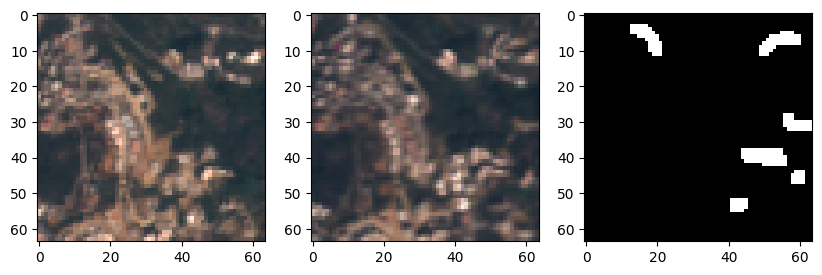

In [44]:
def show_three(im1,im2,lab):
    fig,ax = plt.subplots(1,3,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')

def show_four(im1,im2,lab,pred):
    fig,ax = plt.subplots(1,4,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')
    ax[3].imshow(pred[:,:,0], cmap='gray')

def random_from_triplet(triplets):
    sample = np.random.randint(0,len(triplets[0]))
    print("#"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    #im1.shape,im2.shape,target.shape
    return im1,im2,lab

def show_rand_tripplet(triplets):
    im1,im2,lab = random_from_triplet(triplets)
    show_three(im1,im2,lab)
    print(np.min(lab), np.max(lab))

show_rand_tripplet(train_triplets)

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
#837
0 1
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)
#401
0 1


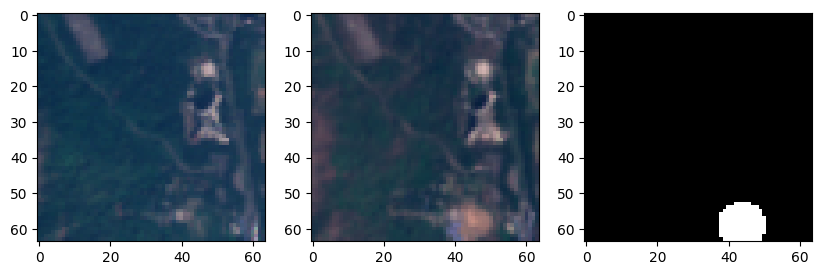

In [29]:
# Train
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
show_rand_tripplet(train_triplets)
#Test
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)
show_rand_tripplet(test_triplets)

In [45]:
import segmentation_models as sm
#import keras
from tensorflow import keras

sm.set_framework('tf.keras') # for Collab ~
sm.framework()

keras.backend.set_image_data_format('channels_last')

In [46]:
# Dataset:
## train_triplets, test_triplets => x_train, y_train, x_val, y_val

# dummy approach pixel differencing at the input!

def keras_dataset_differencingPixels(triplets):
    # input triples
    # outputs x, y
    train_im1, train_im2, train_labels = triplets
    print("in", train_im1.shape, train_im2.shape, train_labels.shape)

    x = train_im1 - train_im2
    y = train_labels

    x = x.astype(np.float32)
    y = y.astype(np.float32)
    print("out", x.shape, y.shape, "types:", x.dtype, y.dtype)
    return x, y

x_train, y_train = keras_dataset_differencingPixels(train_triplets)
x_val, y_val = keras_dataset_differencingPixels(test_triplets)

in (1044, 64, 64, 3) (1044, 64, 64, 3) (1044, 64, 64, 1)
out (1044, 64, 64, 3) (1044, 64, 64, 1) types: float32 float32
in (663, 64, 64, 3) (663, 64, 64, 3) (663, 64, 64, 1)
out (663, 64, 64, 3) (663, 64, 64, 1) types: float32 float32


In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_34   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_3… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_35   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_36   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_37   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model1.keras")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 417ms/step - auc_1: 0.7217 - iou_score: 0.1574 - loss: 1.2757 - val_auc_1: 0.4796 - val_iou_score: 0.0129 - val_loss: 1.5244
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - auc_1: 0.8901 - iou_score: 0.3389 - loss: 0.8963 - val_auc_1: 0.5017 - val_iou_score: 0.0194 - val_loss: 1.1960
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc_1: 0.9250 - iou_score: 0.4299 - loss: 0.7747 - val_auc_1: 0.4984 - val_iou_score: 0.0038 - val_loss: 1.2975
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - auc_1: 0.9286 - iou_score: 0.4514 - loss: 0.7450 - val_auc_1: 0.4993 - val_iou_score: 0.0031 - val_loss: 1.3109
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc_1: 0.9495 - iou_score: 0.5383 - loss: 0.6270 - val_auc_1: 0.5000 - val_iou_score: 0.0011 - val_loss: 1.3729
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc_1: 0.9570 - iou_score: 0.5674 - loss: 0.5762 - val_auc_1: 0.5010 - val_iou_score: 0.0016 - val_loss: 1.4853
Epoch 7

#458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction visualization


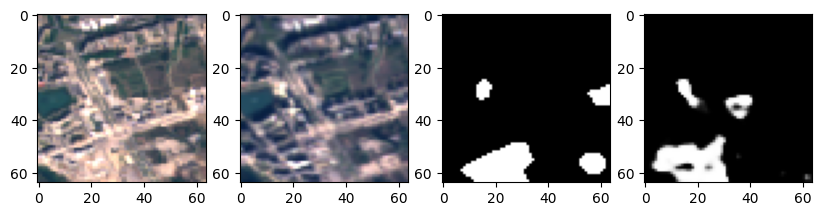

In [ ]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

predict_with_model_rand(test_triplets)

In [ ]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 73,333,764 (279.75 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

 Optimizer params: 48,877,610 (186.45 MB)

In [ ]:
h = history.history
print(history.history.keys())

dict_keys(['auc_1', 'iou_score', 'loss', 'val_auc_1', 'val_iou_score', 'val_loss'])


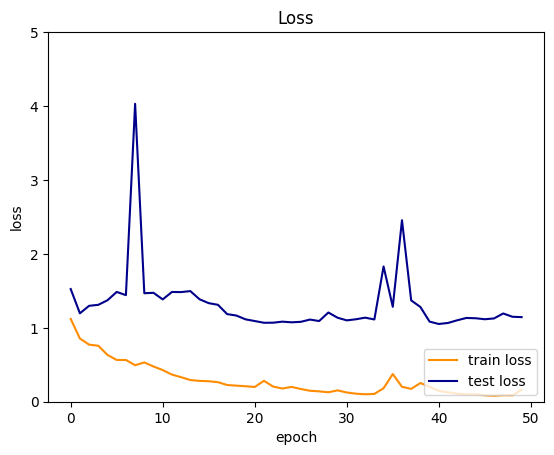

In [ ]:
plt.figure()
plt.plot(h['loss'], color='darkorange', label='train loss')
plt.plot(h['val_loss'], color='darkblue', label='test loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_loss.png")
#plt.close()

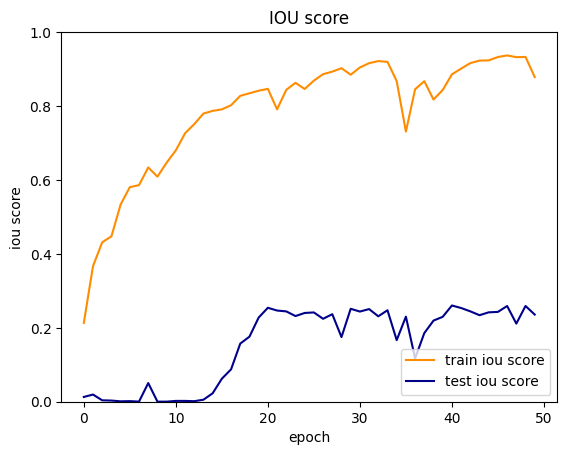

In [ ]:
plt.figure()
plt.plot(h['iou_score'], color='darkorange', label='train iou score')
plt.plot(h['val_iou_score'], color='darkblue', label='test iou score')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.title('IOU score')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_iou.png")
#plt.close()

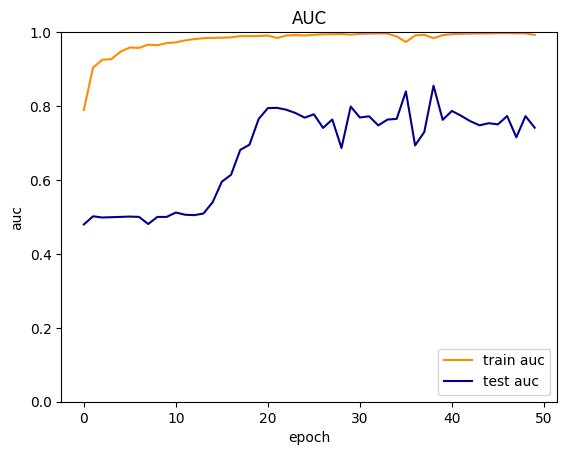

In [ ]:
plt.figure()
plt.plot(h['auc_1'], color='darkorange', label='train auc')
plt.plot(h['val_auc_1'], color='darkblue', label='test auc')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('AUC')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist.png")
#plt.close()

#0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction visualization
#251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction visualization
#158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction visualization
#187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction visualization
#511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction visualization
#191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction visualization
#9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction visualization
#11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction visualization
#610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction visualization
#557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction visualization


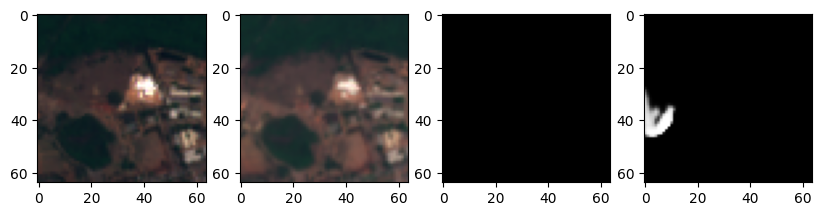

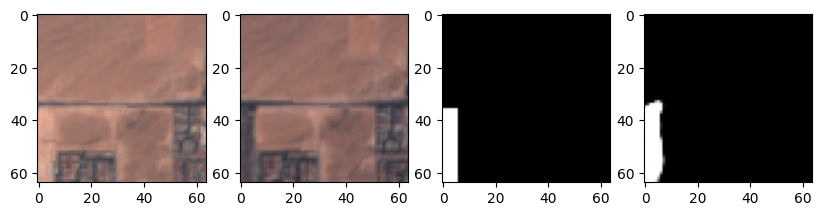

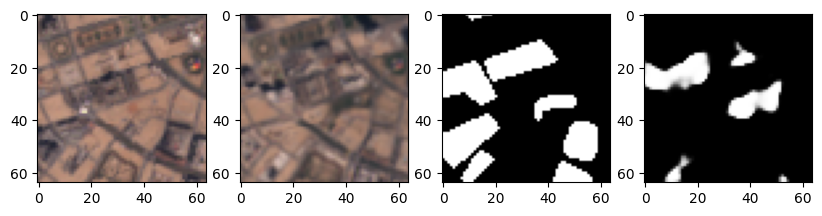

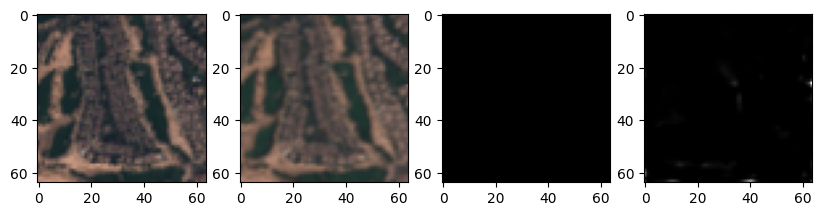

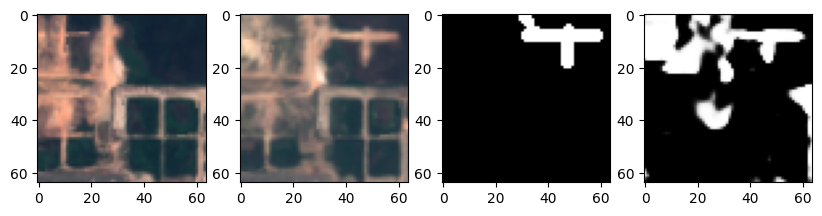

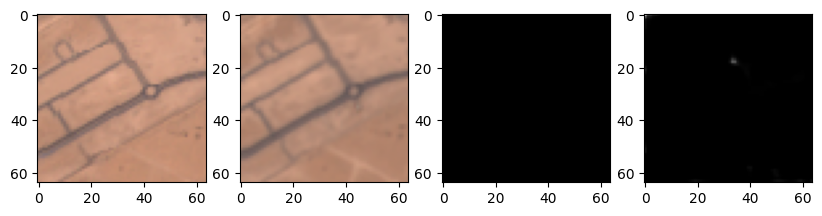

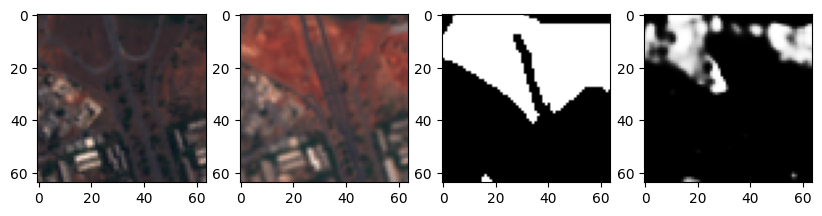

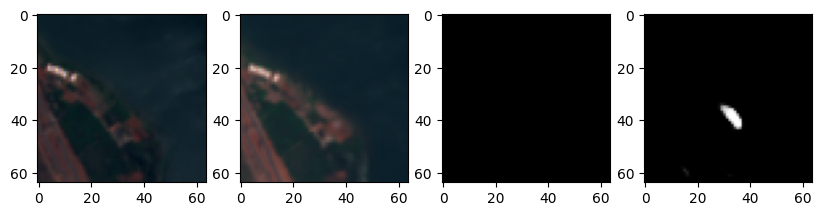

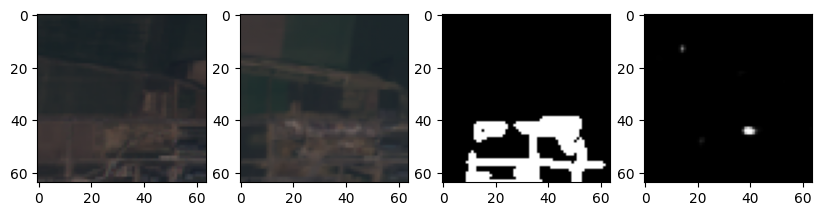

In [ ]:
for _ in range(20,30):
  predict_with_model_rand(test_triplets)
  #predict_with_model_rand(train_triplets)

In [ ]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-58-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


In [ ]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step


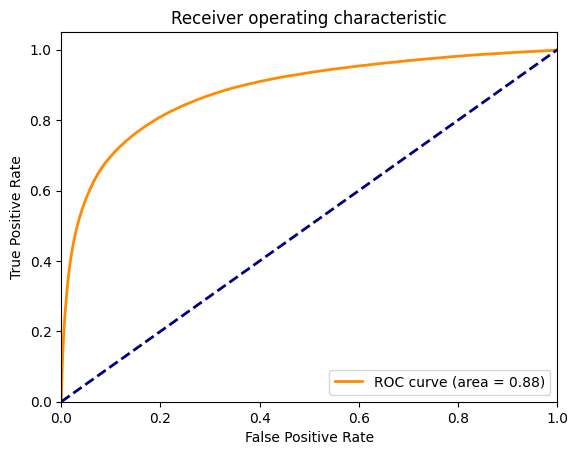

Finished with AUC (test set) = 0.8809687929867408
              precision    recall  f1-score   support

   no change       0.97      0.98      0.97   2569623
      change       0.57      0.38      0.46    146025

    accuracy                           0.95   2715648
   macro avg       0.77      0.68      0.71   2715648
weighted avg       0.94      0.95      0.95   2715648

[[2527091   42532]
 [  90448   55577]]
saving to... test.txt
Recall 0.3805992124636192 Prec 0.5664821779857098 Acc 0.9510319452300151 F1 0.45529913899743585
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


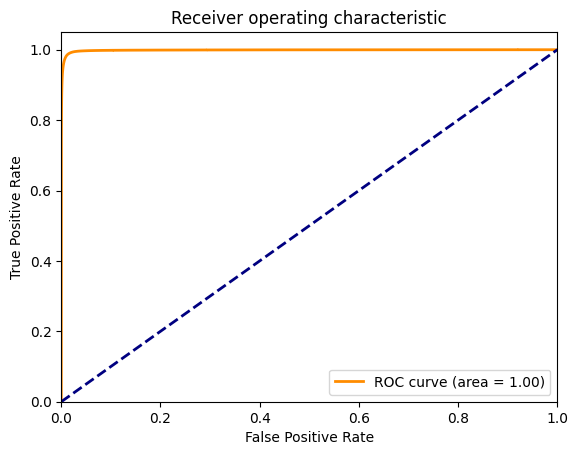

Finished with AUC (train set) = 0.998687974580118
              precision    recall  f1-score   support

   no change       0.99      1.00      1.00   3826130
      change       0.96      0.96      0.96    450094

    accuracy                           0.99   4276224
   macro avg       0.98      0.98      0.98   4276224
weighted avg       0.99      0.99      0.99   4276224

[[3809772   16358]
 [  19260  430834]]
saving to... train.txt
Recall 0.957208938577275 Prec 0.96342063364282 Acc 0.9916706889068486 F1 0.9603047411861992


In [ ]:
predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

In [ ]:
L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)

    return (p0 - pe) / (1 - pe)

def test(triplets):
    predictions, ground_truths = predict_with_model_all(triplets)

    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    if True:
        ### predictions, ground_truths
        """
        c = (predictions.int() == ground_truths.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(ground_truths[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
        """
        tot_count += np.prod(ground_truths.shape)

        # Our net predicts <0 to 1> which makes sense to threshold at 0.5
        # The other code was likely predicting at - to + / or / 0 to non0

        #pr = (predictions.int() > 0) # maybe predictions are from -1 to +1 ? # or 0 and non0
        #gt = (ground_truths.int() > 0)
        pr = (predictions > 0.5)
        gt = (ground_truths > 0.5)

        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()

    #net_loss = tot_loss/tot_count
    #net_loss = float(net_loss.cpu().numpy())

    net_accuracy = 100 * (tp + tn)/tot_count

    #for i in range(n):
    #    class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
    #    class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, dice, prec_nc, rec_nc]

    k = kappa(tp, tn, fp, fn)

    return {    #'net_loss': net_loss,
            'net_accuracy': net_accuracy,
            'class_accuracy': class_accuracy,
            'precision': prec,
            'recall': rec,
            'dice': dice,
            'kappa': k}

results = test(test_triplets)
pprint(results)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
{'class_accuracy': [0.0, 0.0],
 'dice': np.float64(0.45529913899743585),
 'kappa': np.float64(0.43069493234010764),
 'net_accuracy': np.float64(95.1031945230015),
 'precision': np.float64(0.5664821779857098),
 'recall': np.float64(0.3805992124636192)}


### Resnet50

In [13]:
import segmentation_models as sm

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model1.keras")

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 32,561,114 (124.21 MB)

 Trainable params: 32,513,556 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 100s 626ms/step - auc: 0.7332 - iou_score: 0.1579 - loss: 1.2139 - val_auc: 0.4997 - val_iou_score: 0.0081 - val_loss: 1.9572
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - auc: 0.8798 - iou_score: 0.3231 - loss: 0.9147 - val_auc: 0.4806 - val_iou_score: 0.0158 - val_loss: 1.2144
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - auc: 0.9221 - iou_score: 0.3986 - loss: 0.8142 - val_auc: 0.5069 - val_iou_score: 0.0049 - val_loss: 1.2915
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - auc: 0.9285 - iou_score: 0.4278 - loss: 0.7697 - val_auc: 0.5668 - val_iou_score: 0.0071 - val_loss: 1.2576
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - auc: 0.9434 - iou_score: 0.4858 - loss: 0.6946 - val_auc: 0.4992 - val_iou_score: 6.4284e-04 - val_loss: 1.7017
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - auc: 0.9557 - iou_score: 0.5360 - loss: 0.6172 - val_auc: 0.4979 - val_iou_score: 0.0011 - val_loss: 1.3999
Epoch 7/50
66/66 ━━━━━━

#78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction visualization


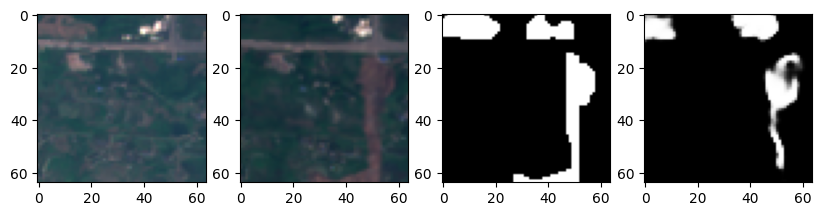

In [15]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

predict_with_model_rand(test_triplets)

In [17]:
h = history.history
print(history.history.keys())

dict_keys(['auc', 'iou_score', 'loss', 'val_auc', 'val_iou_score', 'val_loss'])


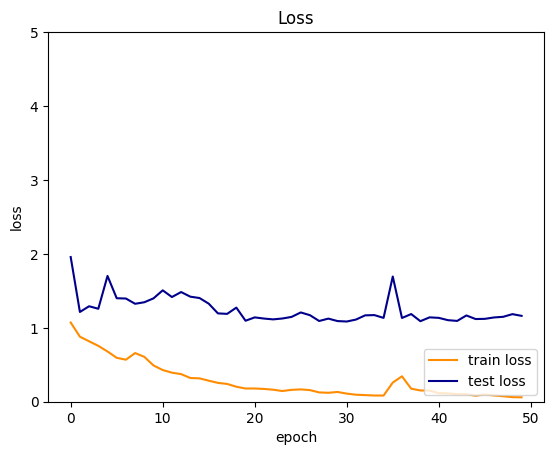

In [18]:
plt.figure()
plt.plot(h['loss'], color='darkorange', label='train loss')
plt.plot(h['val_loss'], color='darkblue', label='test loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_loss.png")
#plt.close()

In [19]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-19-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step


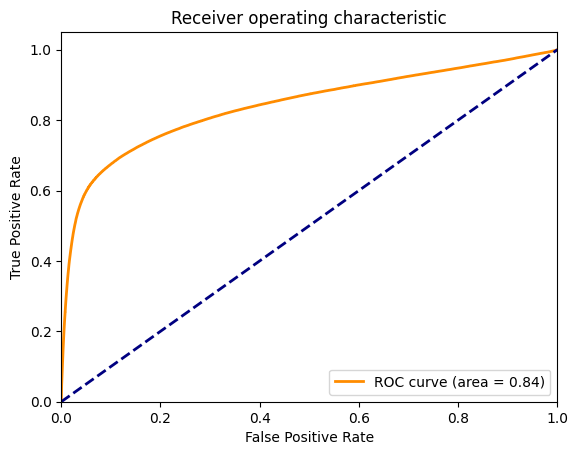

Finished with AUC (test set) = 0.8403322937433274
              precision    recall  f1-score   support

   no change       0.97      0.98      0.98   2569623
      change       0.59      0.38      0.47    146025

    accuracy                           0.95   2715648
   macro avg       0.78      0.68      0.72   2715648
weighted avg       0.95      0.95      0.95   2715648

[[2530628   38995]
 [  89857   56168]]
saving to... test.txt
Recall 0.3846464646464646 Prec 0.5902293958786503 Acc 0.9525520244155354 F1 0.46576114897921955
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step


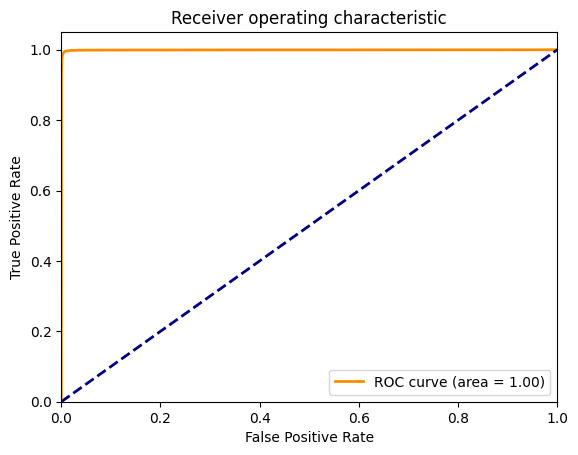

Finished with AUC (train set) = 0.9992384426598352
              precision    recall  f1-score   support

   no change       1.00      1.00      1.00   3826130
      change       0.98      0.98      0.98    450094

    accuracy                           1.00   4276224
   macro avg       0.99      0.99      0.99   4276224
weighted avg       1.00      1.00      1.00   4276224

[[3818259    7871]
 [   8453  441641]]
saving to... train.txt
Recall 0.981219478597804 Prec 0.982489900158394 Acc 0.9961826134458812 F1 0.9818542784285565


In [20]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

### Resnet101

In [32]:
import segmentation_models as sm

BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model4.keras")

171164896/171164896 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_18   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_1… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_19   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 51,605,466 (196.86 MB)

 Trainable params: 51,505,684 (196.48 MB)

 Non-trainable params: 99,782 (389.77 KB)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 155s 855ms/step - auc_1: 0.7096 - iou_score: 0.1437 - loss: 1.4500 - val_auc_1: 0.5147 - val_iou_score: 0.0312 - val_loss: 1.2424
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 142ms/step - auc_1: 0.8833 - iou_score: 0.3086 - loss: 0.9284 - val_auc_1: 0.4972 - val_iou_score: 0.0450 - val_loss: 6.5672
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - auc_1: 0.8944 - iou_score: 0.3212 - loss: 0.9086 - val_auc_1: 0.5002 - val_iou_score: 4.9120e-04 - val_loss: 1.8223
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - auc_1: 0.9097 - iou_score: 0.3712 - loss: 0.8480 - val_auc_1: 0.5000 - val_iou_score: 2.2651e-08 - val_loss: 1.8294
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - auc_1: 0.9155 - iou_score: 0.3726 - loss: 0.8437 - val_auc_1: 0.4998 - val_iou_score: 3.1706e-04 - val_loss: 1.8044
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - auc_1: 0.9288 - iou_score: 0.4311 - loss: 0.7721 - val_auc_1: 0.4983 - val_iou_score: 0.0013 - val

#322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction visualization


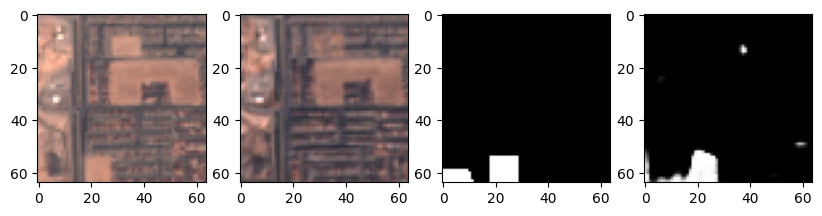

In [34]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

# prompt: show_four(im1,im2,lab,y_pred) plot this

predict_with_model_rand(test_triplets)

In [35]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-35-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step


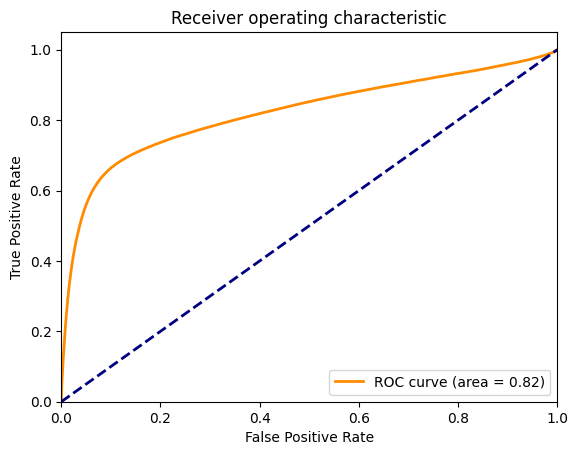

Finished with AUC (test set) = 0.820494474736254
              precision    recall  f1-score   support

   no change       0.97      0.98      0.97   2569623
      change       0.49      0.41      0.45    146025

    accuracy                           0.95   2715648
   macro avg       0.73      0.69      0.71   2715648
weighted avg       0.94      0.95      0.94   2715648

[[2507204   62419]
 [  85617   60408]]
saving to... test.txt
Recall 0.41368258859784285 Prec 0.49181368917257606 Acc 0.945487780448718 F1 0.44937735259548006
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step


Finished with AUC (train set) = 0.9974337568397741
              precision    recall  f1-score   support

   no change       0.99      0.99      0.99   3826130
      change       0.96      0.95      0.95    450094

    accuracy                           0.99   4276224
   macro avg       0.97      0.97      0.97   4276224
weighted avg       0.99      0.99      0.99   4276224

[[3806331   19799]
 [  22350  427744]]
saving to... train.txt
Recall 0.9503437059814173 Prec 0.9557606755105096 Acc 0.9901434068935584 F1 0.9530444934867881


In [36]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

### Resnext50

In [48]:
import segmentation_models as sm

BACKBONE = 'resnext50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator

# callbacks = [
#     keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_iou_score', save_best_only=True)
# ]

history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
  #  callbacks=callbacks,
)

model.save("modelResNext.keras")

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_71   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_7… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_72   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      8,192 │ pooling0[0][0]    │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        512 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_73   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_512 (Lambda) │ (None, None,      │          0 │ zero_padding2d_7… │
│                     │ None, 4)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_513 (Lambda) │ (None, None,      │          0 │ zero_padding2d_7… │
│                     │ None, 4)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_514 (Lambda) │ (None, None,      │          0 │ zero_padding2d_7… │
│                     │ None, 4)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_515 (Lambda) │ (None, None,      │          0 │ zero_padding2d_7… │
│                     │ None, 4)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_516 (Lambda) │ (None, None,      │          0 │ zero_padding2d_7

 Total params: 32,063,194 (122.31 MB)

 Trainable params: 31,992,980 (122.04 MB)

 Non-trainable params: 70,214 (274.27 KB)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - auc_3: 0.7566 - iou_score: 0.1823 - loss: 1.1798 - val_auc_3: 0.4996 - val_iou_score: 0.0153 - val_loss: 2.1380
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - auc_3: 0.8924 - iou_score: 0.3423 - loss: 0.8876 - val_auc_3: 0.4920 - val_iou_score: 0.0502 - val_loss: 11.6880
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - auc_3: 0.9089 - iou_score: 0.3700 - loss: 0.8498 - val_auc_3: 0.4956 - val_iou_score: 0.0053 - val_loss: 1.2910
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - auc_3: 0.9292 - iou_score: 0.4304 - loss: 0.7729 - val_auc_3: 0.4949 - val_iou_score: 0.0031 - val_loss: 1.3138
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - auc_3: 0.9413 - iou_score: 0.4738 - loss: 0.7093 - val_auc_3: 0.5132 - val_iou_score: 0.0054 - val_loss: 1.2720
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - auc_3: 0.9494 - iou_score: 0.5066 - loss: 0.6602 - val_auc_3: 0.4999 - val_iou_score: 0.0019 - val_loss: 1.3333
E

In [63]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

# prompt: show_four(im1,im2,lab,y_pred) plot this

predict_with_model_rand(test_triplets)

#493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction visualization


In [64]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-64-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 382ms/step


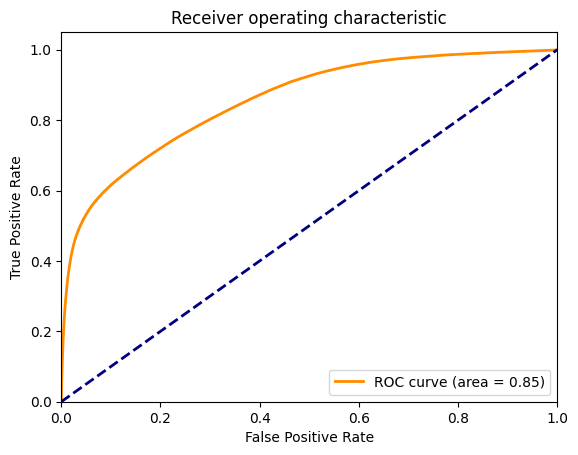

Finished with AUC (test set) = 0.8543449869624793
              precision    recall  f1-score   support

   no change       0.96      0.99      0.98   2569623
      change       0.66      0.28      0.39    146025

    accuracy                           0.95   2715648
   macro avg       0.81      0.63      0.68   2715648
weighted avg       0.94      0.95      0.94   2715648

[[2548879   20744]
 [ 105552   40473]]
saving to... test.txt
Recall 0.2771648690292758 Prec 0.6611398794452521 Acc 0.9534932362368024 F1 0.3905868501558564
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step


Finished with AUC (train set) = 0.9988516541412346
              precision    recall  f1-score   support

   no change       0.99      1.00      0.99   3826130
      change       0.99      0.93      0.96    450094

    accuracy                           0.99   4276224
   macro avg       0.99      0.96      0.98   4276224
weighted avg       0.99      0.99      0.99   4276224

[[3820719    5411]
 [  33524  416570]]
saving to... train.txt
Recall 0.9255177807302475 Prec 0.9871771477862747 Acc 0.9908950045647749 F1 0.9553536106412865


In [65]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

###Augmentation part

In [9]:
#### [CONFIG] ####

# model =========================================

#BACKBONE = 'resnet34'
BACKBONE = 'resnet18'

# model training ==================================

epochs = 30

train_augmentations = True # random flips and rotations, doubles the training dataset
second_round_of_slower_lr_training = True # might not help actually...
slower_epochs = 30

# dataset =========================================

## note: filter and overlap applies only to the training set

tile_size = 64
overlap = 32

filter_enough_change = True
#change_pix_percent = 0.0 # has at least some change
change_pix_percent = 0.03 # has at least 3% change (1044 samples)

# Class re-weighing?
#  referential solution uses: weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix] # FP_MODIFIER=10
weights = [0.4595, 1.9540] # roughly 1 : 4.2

# channels ================================================
LOADING_METHOD = 'rgb_from_pngs'
#LOADING_METHOD = 'channels_from_tifs'

custom_weights_file = "imagenet" # < Only 3 channel ~ RGB can have this!
mode = 'rgb' # 3 channels


#custom_weights_file = None     ### <<< FROM SCRATCH! (maybe quite hard...)
#mode = 'highres' # 10 channels
#mode = 'all' # 13 channels


####=========

# Not possible to display with these anymore ...
NORMALISE_IMGS=True # should be

# ??? maybe band by band normalization ... (images in the pairs folder may be already processed in another way?)
# => get the performance with the png data to the one loaded from the tifs (what is the difference?)


### Faster:
#train_augmentations = False
#second_round_of_slower_lr_training = False
#epochs = 10

In [10]:

import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import sklearn.metrics
# all ch loading:
import shutil
from glob import glob
from skimage import io

from tqdm import tqdm
from pprint import pprint

In [11]:
img_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
test_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"
train_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"

In [12]:

# slightly different folder struct
def copy_dir_to(source, des):
  listdirs = glob(os.path.join(source, "*/"))
  for dir in listdirs:
    dir_name = dir[dir[:-1].rfind("/")+1:-1]
    shutil.copytree(src = os.path.join(dir, "cm"), dst = os.path.join(des, dir_name, "cm"))

copy_dir_to(train_dir, img_dir)
copy_dir_to(test_dir, img_dir)


In [13]:
import random
from scipy.ndimage import zoom
from math import floor, ceil, sqrt, exp


def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""

    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape

    # pad if necessary
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])

    return np.pad(I,((0,p0),(0,p1)),'edge')


def read_sentinel_img(path, NORMALISE_IMGS):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")

    I = np.stack((r,g,b),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I


def read_sentinel_img_leq20(path, NORMALISE_IMGS):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path, NORMALISE_IMGS):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I


def load_sentinel_2_bands(path, mode = 'rgb', NORMALISE_IMGS=True):
    if mode == 'rgb':
        I = read_sentinel_img(path,NORMALISE_IMGS)
    if mode == 'highres': # 10 high res bands
        I = read_sentinel_img_leq20(path,NORMALISE_IMGS)
    if mode == 'all': # all 13 bands
        I = read_sentinel_img_leq60(path,NORMALISE_IMGS)

    #print("loaded", path.replace("/content/OSCD/Onera Satellite Change Detection dataset - Images/",""), "in", mode, ":", I.shape)
    return I

def read_sentinel_img_trio(path, mode, NORMALISE_IMGS=True):
    """Read cropped Sentinel-2 image pair and change map."""
    # read images
    I1 = load_sentinel_2_bands(path+"imgs_1/", mode, NORMALISE_IMGS)
    I2 = load_sentinel_2_bands(path+"imgs_1/", mode, NORMALISE_IMGS)

    #cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0
    lab = Image.open(path + '/cm/cm.png').convert('L') # LA is with transparency
    lab = np.array(lab) / 255 # scale 0 or 1
    lab = lab.astype(np.uint8)
    lab = np.expand_dims(lab, axis=2)

    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')

    return I1, I2, lab

def check_values(A):
    print("min,mix,mean:",np.min(L), np.max(A), np.mean(A))

# usage:
#path = '/content/OSCD/Onera Satellite Change Detection dataset - Images/milano/'
#L,R,V = read_sentinel_img_trio(path, mode = 'rgb', NORMALISE_IMGS=False)
#print(L.shape, R.shape, V.shape)

#check_values(L)
#check_values(R)
#check_values(V)

In [14]:
def has_change(lab):
    num_ones = np.count_nonzero(lab.flatten() == 1.0)
    num_all_pixels = len(lab.flatten())
    perc_change = num_ones / num_all_pixels

    return perc_change > change_pix_percent
    #return np.max(lab) == 1.0

def tile_image(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape

    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)

    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]

            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False, mode = 'rgb', NORMALISE_IMGS=True):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    city_path = []
    img1_paths = []
    img2_paths = []
    label_paths = []
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")
        city_path.append(img_dir + "/" + city + "/")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1,im2,lab = read_sentinel_img_trio(city_path[img_idx], mode, NORMALISE_IMGS)

        """
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)
        """
        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image(im1, im2, lab, overlap_for_tiling, filter_on)
        print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [15]:
def tile_image_from_png(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape

    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)

    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]

            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder_from_png(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    img1_paths = []   # creating list of imagery paths for first set of images
    img2_paths = []   # creating list of imagery paths for second set of images
    label_paths = []  # creating list of change mask paths for the images
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)

        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        #print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image_from_png(im1, im2, lab, overlap_for_tiling, filter_on)
        #print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [16]:
def show_three(im1,im2,lab, save_name = ""):
    fig,ax = plt.subplots(1,3,figsize=(10,10))

    #print(im1.shape) can be (64, 64, 10)
    ax[0].imshow(im1[:,:,0:3])
    ax[1].imshow(im2[:,:,0:3])
    ax[2].imshow(lab[:,:,0], cmap='gray')

    if len(save_name) > 0:
        plt.savefig(save_name)

def show_four(im1,im2,lab,pred, save_name = ""):
    fig,ax = plt.subplots(1,4,figsize=(10,10))
    ax[0].imshow(im1[:,:,0:3])
    ax[1].imshow(im2[:,:,0:3])
    ax[2].imshow(lab[:,:,0], cmap='gray')
    ax[3].imshow(pred[:,:,0], cmap='gray')

    if len(save_name) > 0:
        plt.savefig(save_name)

def random_from_triplet(triplets):
    sample = np.random.randint(0,len(triplets[0]))
    print("#"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    #im1.shape,im2.shape,target.shape
    return im1,im2,lab

def show_rand_tripplet(triplets):
    im1,im2,lab = random_from_triplet(triplets)
    show_three(im1,im2,lab)
    print(np.min(lab), np.max(lab))

In [18]:
# train_cities = [name for name in os.listdir(train_dir) if os.path.isdir(train_dir+"/"+name)]
# test_cities = [name for name in os.listdir(test_dir) if os.path.isdir(test_dir+"/"+name)]
# print("train cities:", len(train_cities), "test cities:", len(test_cities))
train_cities = sorted([f for f in os.listdir(train_dir) if not f.startswith('.')])
test_cities = sorted([f for f in os.listdir(test_dir) if not f.startswith('.')])

print(train_cities)
print(test_cities)
print("train cities:", len(train_cities), "test cities:", len(test_cities))

if LOADING_METHOD == 'channels_from_tifs':
    train_triplets = dataset_from_folder(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change,
                                     mode = mode, NORMALISE_IMGS = NORMALISE_IMGS)
    test_triplets = dataset_from_folder(test_cities,test_dir,
                                    mode = mode, NORMALISE_IMGS = NORMALISE_IMGS) # without overlap! and without filterings!

elif LOADING_METHOD == 'rgb_from_pngs':
    train_triplets = dataset_from_folder_from_png(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change)
    test_triplets = dataset_from_folder_from_png(test_cities,test_dir) # without overlap! and without filterings!

print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)

# previous:
#Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
#Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)

['abudhabi', 'aguasclaras', 'beihai', 'beirut', 'bercy', 'bordeaux', 'cupertino', 'hongkong', 'mumbai', 'nantes', 'paris', 'pisa', 'rennes', 'saclay_e']
['brasilia', 'chongqing', 'dubai', 'lasvegas', 'milano', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia']
train cities: 14 test cities: 10
Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)


In [19]:
# from my code at https://github.com/previtus/ChangeDetectionProject/blob/ad2bd4adb2df7a2125b0737af385572d2d743e75/ActiveLearning/TrainTestHandler.py#L42

if train_augmentations:
    print("Before Augmentation:")
    print("Images 1", train_triplets[0].shape, "Images 1", train_triplets[1].shape, "Labels", train_triplets[2].shape)

    train_L, train_R, train_V = train_triplets


    from albumentations.core.transforms_interface import DualTransform
    class RandomRotate90x1(DualTransform):
                def apply(self, img, factor=0, **params):
                    return np.ascontiguousarray(np.rot90(img, factor))

                def get_params(self):
                    return {'factor': 1}

    class RandomRotate90x2(DualTransform):
                def apply(self, img, factor=0, **params):
                    return np.ascontiguousarray(np.rot90(img, factor))

                def get_params(self):
                    return {'factor': 2}

    class RandomRotate90x3(DualTransform):
                def apply(self, img, factor=0, **params):
                    return np.ascontiguousarray(np.rot90(img, factor))

                def get_params(self):
                    return {'factor': 3}

    from albumentations import (HorizontalFlip,
                                        VerticalFlip,
                                        Compose)
    from random import randint


    augmentations = []
    augmentations.append( RandomRotate90x1(p=1) ) # 90, 180 or 270 <- we need the same for the same of l=r=y
    augmentations.append( RandomRotate90x2(p=1) ) # 90, 180 or 270 <- we need the same for the same of l=r=y
    augmentations.append( RandomRotate90x3(p=1) ) # 90, 180 or 270 <- we need the same for the same of l=r=y
    augmentations.append( HorizontalFlip(p=1) )         # H reflection
    augmentations.append( VerticalFlip(p=1) )           # V reflection

    augmentations.append( Compose([VerticalFlip(p=1), RandomRotate90x1(p=1)]) ) # V reflection and then rotation
    augmentations.append( Compose([HorizontalFlip(p=1), RandomRotate90x1(p=1)]) ) # H reflection and then rotation

    aug_lefts = []
    aug_rights = []
    aug_ys = []

    num_in_train = len(train_L)
    for i in range(num_in_train):
        #print(i)

        image_l = train_L[i]
        image_r = train_R[i]
        mask = train_V[i]

        if True:
            # choose a random augmentation ... (we don't have mem for all of them!, solve by batches or smth ...)
            aug_i = randint(0, len(augmentations)-1)
            aug = augmentations[aug_i]
            #for aug in augmentations:

            augmented1 = aug(image=image_l, mask=mask)
            augmented2 = aug(image=image_r, mask=mask)
            aug_l = augmented1['image']
            aug_y = augmented1['mask']
            aug_lefts.append(np.asarray(aug_l))
            aug_ys.append(np.asarray(aug_y))
            aug_r = augmented2['image']
            aug_rights.append(np.asarray(aug_r))
            del aug_l
            del aug_r
            del aug_y
            del augmented1
            del augmented2

    aug_lefts = np.asarray(aug_lefts)
    aug_rights = np.asarray(aug_rights)
    aug_ys = np.asarray(aug_ys)

    print("aug_lefts.shape", aug_lefts.shape)
    print("aug_rights.shape", aug_rights.shape)
    print("aug_ys.shape", aug_ys.shape)

    # Adding them to the training set
    train_L = np.append(train_L, aug_lefts, axis=0)
    train_R = np.append(train_R, aug_rights, axis=0)
    train_V = np.append(train_V, aug_ys, axis=0)

    train_triplets = train_L, train_R, train_V

    print("After Augmentation:")
    print("Images 1", train_triplets[0].shape, "Images 1", train_triplets[1].shape, "Labels", train_triplets[2].shape)

Before Augmentation:
Images 1 (1044, 64, 64, 3) Images 1 (1044, 64, 64, 3) Labels (1044, 64, 64, 1)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


aug_lefts.shape (1044, 64, 64, 3)
aug_rights.shape (1044, 64, 64, 3)
aug_ys.shape (1044, 64, 64, 1)
After Augmentation:
Images 1 (2088, 64, 64, 3) Images 1 (2088, 64, 64, 3) Labels (2088, 64, 64, 1)


In [22]:
import segmentation_models as sm
#import keras
from tensorflow import keras

sm.set_framework('tf.keras') # for Collab ~
sm.framework()

keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [24]:
# Dataset:
## train_triplets, test_triplets => x_train, y_train, x_val, y_val

# dummy approach pixel differencing at the input!

def keras_dataset_differencingPixels(triplets):
    # input triples
    # outputs x, y
    train_im1, train_im2, train_labels = triplets
    print("in", train_im1.shape, train_im2.shape, train_labels.shape)

    x = train_im1 - train_im2
    y = train_labels

    x = x.astype(np.float32)
    y = y.astype(np.float32)
    print("out", x.shape, y.shape, "types:", x.dtype, y.dtype)
    return x, y

x_train, y_train = keras_dataset_differencingPixels(train_triplets)
x_val, y_val = keras_dataset_differencingPixels(test_triplets)

in (2088, 64, 64, 3) (2088, 64, 64, 3) (2088, 64, 64, 1)
out (2088, 64, 64, 3) (2088, 64, 64, 1) types: float32 float32
in (663, 64, 64, 3) (663, 64, 64, 3) (663, 64, 64, 1)
out (663, 64, 64, 3) (663, 64, 64, 1) types: float32 float32


In [25]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()


85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [27]:
from keras.optimizers import Adam

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,'accuracy'])

In [30]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model1.keras")

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 251ms/step - accuracy: 0.7579 - iou_score: 0.1757 - loss: 1.3000 - val_accuracy: 0.9462 - val_iou_score: 0.0086 - val_loss: 1.3353
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9182 - iou_score: 0.3686 - loss: 0.8526 - val_accuracy: 0.9442 - val_iou_score: 0.0134 - val_loss: 1.3285
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9249 - iou_score: 0.4031 - loss: 0.8034 - val_accuracy: 0.9462 - val_iou_score: 0.0014 - val_loss: 1.3510
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9308 - iou_score: 0.4427 - loss: 0.7547 - val_accuracy: 0.9462 - val_iou_score: 4.2244e-04 - val_loss: 1.4352
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9374 - iou_score: 0.4887 - loss: 0.6986 - val_accuracy: 0.9462 - val_iou_score: 8.9264e-04 - val_loss: 1.3772
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9419 - iou_score: 0.5013 - loss: 0.6689 - val_accuracy: 

#282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction visualization


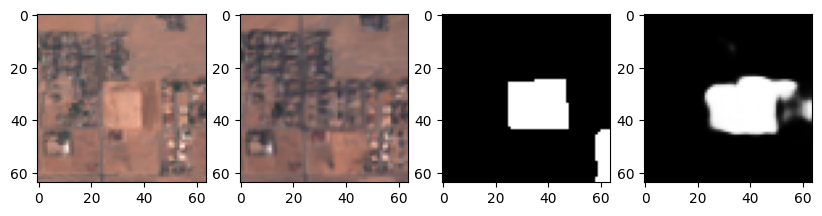

In [52]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

predict_with_model_rand(test_triplets)

In [37]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-37-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step


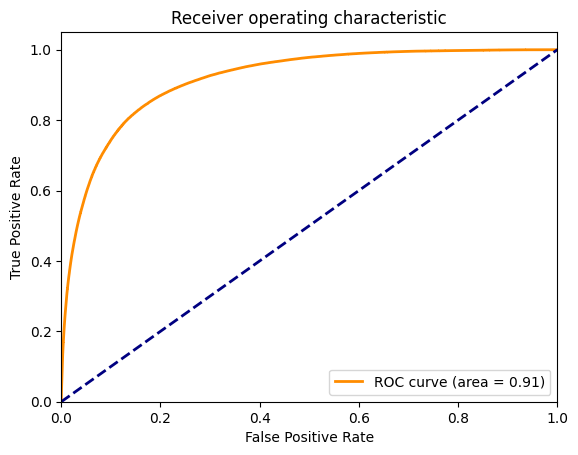

Finished with AUC (test set) = 0.9148123246208119
              precision    recall  f1-score   support

   no change       0.97      0.98      0.97   2569623
      change       0.54      0.40      0.46    146025

    accuracy                           0.95   2715648
   macro avg       0.75      0.69      0.72   2715648
weighted avg       0.94      0.95      0.95   2715648

[[2518526   51097]
 [  87041   58984]]
saving to... test.txt
Recall 0.40393083376134226 Prec 0.5358236207883286 Acc 0.9491325827205882 F1 0.46062177379678726
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


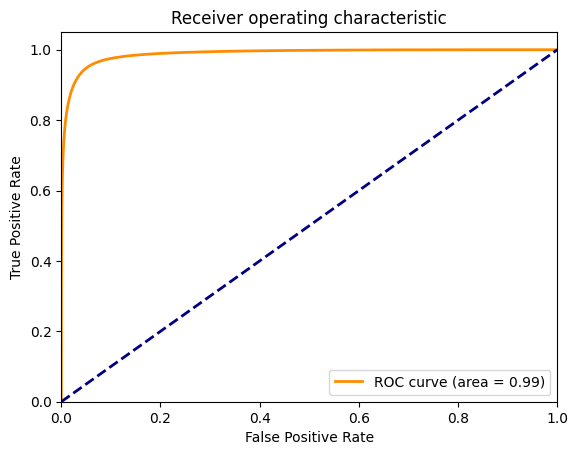

Finished with AUC (train set) = 0.9880516928489733
              precision    recall  f1-score   support

   no change       0.98      0.99      0.98   7652260
      change       0.90      0.83      0.86    900188

    accuracy                           0.97   8552448
   macro avg       0.94      0.91      0.92   8552448
weighted avg       0.97      0.97      0.97   8552448

[[7566546   85714]
 [ 157313  742875]]
saving to... train.txt
Recall 0.825244282305474 Prec 0.8965542627285663 Acc 0.9715839254445043 F1 0.8594225860246868


In [38]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

## Siamese U-NEt

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8g94p1l9
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8g94p1l9
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:
!cat /usr/local/lib/python3.11/dist-packages/segmentation_models/utils.py

""" Utility functions for segmentation models """

from keras_applications import get_submodules_from_kwargs
from . import inject_global_submodules


def set_trainable(model, recompile=True, **kwargs):
    """Set all layers of model trainable and recompile it

    Note:
        Model is recompiled using same optimizer, loss and metrics::

            model.compile(
                model.optimizer,
                loss=model.loss,
                metrics=model.metrics,
                loss_weights=model.loss_weights,
                sample_weight_mode=model.sample_weight_mode,
                weighted_metrics=model.weighted_metrics,
            )

    Args:
        model (``keras.models.Model``): instance of keras model

    """
    for layer in model.layers:
        layer.trainable = True

    if recompile:
        model.compile(
            model.optimizer,
            loss=model.loss,
            metrics=model.metrics,
            loss_weights=model.loss_weights,
            sample_w

In [ ]:
!cat /usr/local/lib/python3.11/dist-packages/segmentation_models/models/unet.py

from keras_applications import get_submodules_from_kwargs

from ._common_blocks import Conv2dBn
from ._utils import freeze_model, filter_keras_submodules
from ..backbones.backbones_factory import Backbones

backend = None
layers = None
models = None
keras_utils = None


# ---------------------------------------------------------------------
#  Utility functions
# ---------------------------------------------------------------------

def get_submodules():
    return {
        'backend': backend,
        'models': models,
        'layers': layers,
        'utils': keras_utils,
    }


# ---------------------------------------------------------------------
#  Blocks
# ---------------------------------------------------------------------

def Conv3x3BnReLU(filters, use_batchnorm, name=None):
    kwargs = get_submodules()

    def wrapper(input_tensor):
        return Conv2dBn(
            filters,
            kernel_size=3,
            activation='relu',
            kernel_initializer='he_

In [ ]:
!cat /usr/local/lib/python3.11/dist-packages/segmentation_models/backbones/backbones_factory.py

import copy
import efficientnet.model as eff
from classification_models.models_factory import ModelsFactory

from . import inception_resnet_v2 as irv2
from . import inception_v3 as iv3


class BackbonesFactory(ModelsFactory):
    _default_feature_layers = {

        # List of layers to take features from backbone in the following order:
        # (x16, x8, x4, x2, x1) - `x4` mean that features has 4 times less spatial
        # resolution (Height x Width) than input image.

        # VGG
        'vgg16': ('block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2'),
        'vgg19': ('block5_conv4', 'block4_conv4', 'block3_conv4', 'block2_conv2', 'block1_conv2'),

        # ResNets
        'resnet18': ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
        'resnet34': ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
        'resnet50': ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),

In [ ]:
!cat /usr/local/lib/python3.11/dist-packages/segmentation_models/backbones/__init__.py

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Subtract, Activation, Conv2D
from tensorflow.keras.models import Model
import segmentation_models as sm

# Set global framework to use
sm.set_framework('tf.keras')
sm.framework()

def build_siamese_unet(
    backbone_name='resnet34',
    input_shape=(None, None, 3),
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet'
):
    # Input layers for the two images
    input_1 = Input(shape=input_shape, name="input_1")
    input_2 = Input(shape=input_shape, name="input_2")

    # Base U-Net model with shared weights
    base_unet = sm.Unet(
        backbone_name=backbone_name,
        input_shape=input_shape,
        encoder_weights=encoder_weights,
        classes=classes,
        activation=None  # remove activation so we can access features
    )

    # Create a feature extractor model (up to last conv layer)
    feature_extractor = Model(
        inputs=base_unet.input,
        outputs=base_unet.get_layer(index=-2).output,  # penultimate layer (before final Conv2D)
        name="shared_unet_feature_extractor"
    )

    # Extract features from both inputs
    features_1 = feature_extractor(input_1)
    features_2 = feature_extractor(input_2)

    # Combine feature maps (change detection)
    merged = Subtract(name='feature_difference')([features_2, features_1])
    merged = Activation('relu')(merged)

    # Final prediction layer
    output = Conv2D(
        filters=classes,
        kernel_size=3,
        padding='same',
        activation=activation,
        name='change_map'
    )(merged)

    # Complete Siamese model
    model = Model(inputs=[input_1, input_2], outputs=output, name="Siamese_UNet")

    return model

# Example usage
if __name__ == "__main__":
    model = build_siamese_unet(
        backbone_name='resnet34',
        input_shape=(256, 256, 3),
        classes=1,
        activation='sigmoid',
        encoder_weights='imagenet'
    )
    model.summary()

Model: "Siamese_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_unet_featur… │ (None, 256, 256,  │ 24,456,154 │ input_1[0][0],    │
│ (Functional)        │ 1)                │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_difference  │ (None, 256, 256,  │          0 │ shared_unet_feat… │
│ (Subtract)          │ 1)                │            │ shared_unet_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256, 256,  │          0 │ feature_differen… │
│ (Activation)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ change_map (Conv2D) │ (None, 256, 256,  │         10 │ activation_5[0][… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,456,164 (93.29 MB)

 Trainable params: 24,438,814 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
BACKBONE = 'resnet34'

# If you want to load pretrained encoder weights (e.g., ImageNet)
custom_weights_file = 'imagenet'

# Define tile size
tile_size = tile_size  # or whatever your input size is

# Build Siamese U-Net model
model = build_siamese_unet(
    input_shape=(tile_size, tile_size, 3),
    backbone_name=BACKBONE,
    encoder_weights=custom_weights_file,
    classes=1,
    activation='sigmoid'
)

print("Model loaded:")
print("model.input:", model.input)
print("model.output:", model.output)


Model loaded:
model.input: [<KerasTensor shape=(None, 64, 64, 3), dtype=float32, sparse=False, ragged=False, name=input_1>, <KerasTensor shape=(None, 64, 64, 3), dtype=float32, sparse=False, ragged=False, name=input_2>]
model.output: <KerasTensor shape=(None, 64, 64, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_811>


In [ ]:
model.summary()

Model: "Siamese_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_unet_featur… │ (None, 64, 64, 1) │ 24,456,154 │ input_1[0][0],    │
│ (Functional)        │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_difference  │ (None, 64, 64, 1) │          0 │ shared_unet_feat… │
│ (Subtract)          │                   │            │ shared_unet_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 64, 64, 1) │          0 │ feature_differen… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ change_map (Conv2D) │ (None, 64, 64, 1) │         10 │ activation_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,456,164 (93.29 MB)

 Trainable params: 24,438,814 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
import segmentation_models as sm

# Get the correct preprocessing function for the backbone
preprocess_input = sm.get_preprocessing(BACKBONE)


In [ ]:
# Dataset:
## train_triplets, test_triplets => x_train, y_train, x_val, y_val

# Model shapes:
# model.input [<tf.Tensor 'input_3:0' shape=(?, 64, 64, 3) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 64, 64, 3) dtype=float32>]
# model.output Tensor("softmax_1/truediv:0", shape=(?, 64, 64, 3), dtype=float32)


def keras_dataset_differencingPixels(triplets):
    # input triples
    # outputs x, y
    train_im1, train_im2, train_labels = triplets
    print("in", train_im1.shape, train_im2.shape, train_labels.shape)

    x = [preprocess_input(train_im1), preprocess_input(train_im2)]
    x = np.asarray(x)
    y = train_labels

    x = x.astype(np.float32)
    y = y.astype(np.float32)
    print("out", x.shape, y.shape, "types:", x.dtype, y.dtype)
    return x, y

x_train, y_train = keras_dataset_differencingPixels(train_triplets)
x_val, y_val = keras_dataset_differencingPixels(test_triplets)

in (1044, 64, 64, 3) (1044, 64, 64, 3) (1044, 64, 64, 1)
out (2, 1044, 64, 64, 3) (1044, 64, 64, 1) types: float32 float32
in (663, 64, 64, 3) (663, 64, 64, 3) (663, 64, 64, 1)
out (2, 663, 64, 64, 3) (663, 64, 64, 1) types: float32 float32


In [ ]:
import segmentation_models as sm
from keras.optimizers import Adam

#bce_jaccard_loss = binary_crossentropy + jaccard_loss
model.compile(optimizer=Adam(learning_rate=0.001), loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,'accuracy'])

In [ ]:
# # Fit the model
# # Reshape y_train to match the expected format for class weights
# y_train_reshaped = y_train.reshape(-1)

# # Convert class weights to a dictionary format
# class_weight_dict = {0: weights[0], 1: weights[1]}  # Assuming classes are 0 and 1

# history = model.fit(
#     x=[x_train[0], x_train[1]],
#     y=y_train,
#     batch_size=16,
#     epochs=epochs,
#     validation_data=([x_val[0], x_val[1]], y_val),
#     class_weight=class_weight_dict  # Use the dictionary here
# )

# Fit the model
# Instead of using class weights directly, calculate sample weights
# based on the pixel values of the target mask
sample_weights = np.zeros(y_train.shape[0])  # Initialize with zeros

# Assign weights based on pixel values in y_train (e.g., 0 or 1)
for i in range(y_train.shape[0]):
    # Assuming 0 and 1 are the class labels in your masks:
    num_class_0 = np.sum(y_train[i] == 0)
    num_class_1 = np.sum(y_train[i] == 1)

    # Calculate weight for the sample
    sample_weights[i] = (num_class_0 * class_weight_dict[0] + num_class_1 * class_weight_dict[1]) / (num_class_0 + num_class_1)

# Now use 'sample_weight' instead of 'class_weight' in model.fit:
history = model.fit(
    x=[x_train[0], x_train[1]],
    y=y_train,
    batch_size=16,
    epochs=epochs,
    validation_data=([x_val[0], x_val[1]], y_val),
    sample_weight=sample_weights  # Use sample_weight instead of class_weight
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 529s 7s/step - accuracy: 0.7965 - iou_score: 0.0880 - loss: 0.9349 - val_accuracy: 0.9462 - val_iou_score: 0.0485 - val_loss: 1.6154
Epoch 2/50
57/66 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.8729 - iou_score: 0.0978 - loss: 0.9188 

KeyboardInterrupt: 

### Siamese unet from scratch

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model, callbacks, optimizers, metrics, losses
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import Sequence
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import cv2
import time
import albumentations as A
from datetime import datetime

In [ ]:
# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Define constants
INPUT_SIZE = (264, 256)
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
BACKBONE = 'vgg16'  # options: 'vgg16', 'resnet50', etc.
WEIGHTS = 'imagenet'
CHANNELS = 3  # RGB images
CLASS_WEIGHTS = {0: 1.0, 1: 10.0}  # Addressing class imbalance

In [ ]:
# Create TensorFlow strategy for GPU training
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
except:
    strategy = tf.distribute.get_strategy()
    print("No distributed training")

Number of devices: 1


In [ ]:
# Custom Data Generator for Siamese Network
class SiameseDataGenerator(Sequence):
    def __init__(self, img_dir, label_dir, cities, batch_size=BATCH_SIZE, img_size=INPUT_SIZE,
                 augment=False, shuffle=True):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.cities = cities
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle

        # List to store all image pairs and corresponding labels
        self.image_pairs = []
        self.labels = []

        # Initialize data
        self._load_data()

        # Create augmentation pipeline
        self.aug_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
        ])

        # Initial shuffling
        if self.shuffle:
            self.on_epoch_end()

    def _load_data(self):
        """Load all image pairs and labels into memory"""
        for city in self.cities:
            # Get all time points for the city
            time_dirs = sorted(glob.glob(os.path.join(self.img_dir, city, 'imgs_*_rect')))

            if len(time_dirs) < 2:
                continue

            # Get time point 1 and time point 2 images
            t1_imgs = sorted(glob.glob(os.path.join(time_dirs[0], '*.png')))
            t2_imgs = sorted(glob.glob(os.path.join(time_dirs[1], '*.png')))

            # Get corresponding labels
            label_paths = sorted(glob.glob(os.path.join(self.label_dir, city, '*.png')))

            # Ensure we have matching image pairs and labels
            assert len(t1_imgs) == len(t2_imgs) == len(label_paths), \
                f"Mismatch in dataset for city {city}: {len(t1_imgs)} t1, {len(t2_imgs)} t2, {len(label_paths)} labels"

            # Store paths
            for t1_path, t2_path, label_path in zip(t1_imgs, t2_imgs, label_paths):
                self.image_pairs.append((t1_path, t2_path))
                self.labels.append(label_path)

    def __len__(self):
        """Return the number of batches per epoch"""
        return int(np.ceil(len(self.image_pairs) / self.batch_size))

    def __getitem__(self, idx):
        """Generate one batch of data"""
        # Get indices for this batch
        indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Initialize batch arrays
        batch_t1 = np.zeros((len(indices), *self.img_size, CHANNELS), dtype=np.float32)
        batch_t2 = np.zeros((len(indices), *self.img_size, CHANNELS), dtype=np.float32)
        batch_y = np.zeros((len(indices), *self.img_size, 1), dtype=np.float32)

        # Fill batch arrays
        for i, index in enumerate(indices):
            # Get image paths
            t1_path, t2_path = self.image_pairs[index]
            label_path = self.labels[index]

            # Read images
            t1_img = cv2.imread(t1_path)
            t1_img = cv2.cvtColor(t1_img, cv2.COLOR_BGR2RGB)
            t1_img = cv2.resize(t1_img, self.img_size)

            t2_img = cv2.imread(t2_path)
            t2_img = cv2.cvtColor(t2_img, cv2.COLOR_BGR2RGB)
            t2_img = cv2.resize(t2_img, self.img_size)

            # Read label
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            label = cv2.resize(label, self.img_size)
            label = (label > 0).astype(np.float32)
            label = np.expand_dims(label, axis=-1)

            # Apply augmentation if needed
            if self.augment:
                augmented = self.aug_transform(image=t1_img, image1=t2_img, mask=label[:,:,0])
                t1_img = augmented['image']
                t2_img = augmented['image1']
                label = np.expand_dims(augmented['mask'], axis=-1)

            # Normalize images to [0, 1]
            t1_img = t1_img.astype(np.float32) / 255.0
            t2_img = t2_img.astype(np.float32) / 255.0

            # Store in batch arrays
            batch_t1[i] = t1_img
            batch_t2[i] = t2_img
            batch_y[i] = label

        # Return inputs and outputs
        return [batch_t1, batch_t2], batch_y

    def on_epoch_end(self):
        """Updates indices after each epoch"""
        self.indices = np.arange(len(self.image_pairs))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Building the encoder (feature extractor)
def build_encoder(input_shape, backbone_name=BACKBONE):
    """Build encoder for feature extraction"""
    inputs = layers.Input(shape=input_shape)

    # Preprocessing layer (normalize to the range expected by the pretrained model)
    x = inputs

    # Choose backbone
    if backbone_name == 'vgg16':
        base_model = VGG16(weights=WEIGHTS, include_top=False, input_shape=input_shape)
        # Collect intermediate outputs for skip connections
        skip_connections = [
            base_model.get_layer('block1_conv2').output,  # 64 filters
            base_model.get_layer('block2_conv2').output,  # 128 filters
            base_model.get_layer('block3_conv3').output,  # 256 filters
            base_model.get_layer('block4_conv3').output,  # 512 filters
            base_model.get_layer('block5_conv3').output   # 512 filters
        ]

    elif backbone_name == 'resnet50':
        base_model = ResNet50(weights=WEIGHTS, include_top=False, input_shape=input_shape)
        # Collect intermediate outputs for skip connections
        skip_connections = [
            base_model.get_layer('conv1_relu').output,     # 64 filters
            base_model.get_layer('conv2_block3_out').output,  # 256 filters
            base_model.get_layer('conv3_block4_out').output,  # 512 filters
            base_model.get_layer('conv4_block6_out').output,  # 1024 filters
            base_model.get_layer('conv5_block3_out').output   # 2048 filters
        ]
    else:
        raise ValueError(f"Unsupported backbone: {backbone_name}")

    # Create a model that returns skip connections and final output
    encoder_model = Model(inputs=base_model.input, outputs=[*skip_connections, base_model.output])

    return encoder_model

# Building the decoder (upsampling path)
def build_decoder(encoder_outputs, decoder_filters=[256, 128, 64, 32, 16]):
    """Build decoder using encoder outputs and skip connections"""
    # Get the skip connections and bottleneck feature maps
    skip_connections = encoder_outputs[:-1]
    x = encoder_outputs[-1]

    # Go through the upsampling blocks with skip connections
    for i, (skip, filters) in enumerate(zip(reversed(skip_connections), decoder_filters)):
        # Upsampling
        x = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(x)

        # Concatenate with skip connection
        x = layers.Concatenate()([x, skip])

        # Apply convolutions after the concatenation
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)

    # One more upsampling to reach the original image size
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Final layer to produce binary segmentation map
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    return outputs

In [ ]:
# Building the Siamese U-Net
def build_siamese_unet(input_shape=(256, 256, 3), backbone_name=BACKBONE):
    """Build the complete Siamese U-Net architecture"""
    with strategy.scope():
        # Create shared encoder
        encoder = build_encoder(input_shape, backbone_name)

        # Input layers for the two time points
        input_t1 = layers.Input(shape=input_shape)
        input_t2 = layers.Input(shape=input_shape)

        # Pass both inputs through the same encoder (shared weights)
        outputs_t1 = encoder(input_t1)
        outputs_t2 = encoder(input_t2)

        # Process skip connections and bottleneck features
        processed_outputs = []
        for out_t1, out_t2 in zip(outputs_t1, outputs_t2):
            # Compute the difference between the two feature maps
            diff = layers.Subtract()([out_t1, out_t2])
            # Add absolute difference to the list of processed outputs
            processed_outputs.append(layers.Activation('relu')(diff))

        # Build decoder using the processed feature maps
        output = build_decoder(processed_outputs)

        # Create the final model
        model = Model(inputs=[input_t1, input_t2], outputs=output)

        # Compile the model with weighted loss to address class imbalance
        model.compile(
            optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
            loss=weighted_binary_crossentropy,
            metrics=[
                metrics.BinaryAccuracy(),
                metrics.Precision(),
                metrics.Recall(),
                F1Score()
            ]
        )

    return model

In [ ]:
# Custom F1 Score metric
class F1Score(metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Custom weighted binary crossentropy to address class imbalance
def weighted_binary_crossentropy(y_true, y_pred):
    """Custom weighted loss function to address class imbalance"""
    # Convert class weights to tensor
    class_weights_tensor = tf.constant([CLASS_WEIGHTS[0], CLASS_WEIGHTS[1]], dtype=tf.float32)

    # Compute sample weights based on true class
    sample_weights = tf.gather(class_weights_tensor, tf.cast(y_true, tf.int32))

    # Compute binary crossentropy
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)

    # Apply weights
    weighted_bce = bce * sample_weights

    return tf.reduce_mean(weighted_bce)

# Dice loss function (can be combined with BCE for better performance)
def dice_loss(y_true, y_pred, smooth=1.0):
    """Dice loss function for image segmentation"""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

    return 1 - dice

# Combined loss (BCE + Dice)
def combined_loss(y_true, y_pred):
    """Combine binary crossentropy and dice loss"""
    bce = weighted_binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)

    return bce + dice


In [ ]:
# Function to evaluate model
def evaluate_model(model, test_generator, threshold=0.5):
    """Evaluate model and print metrics"""
    # Predict on test set
    y_pred_all = []
    y_true_all = []

    for i in range(len(test_generator)):
        [x1, x2], y_true = test_generator[i]
        y_pred = model.predict([x1, x2])

        y_pred_all.append(y_pred)
        y_true_all.append(y_true)

    # Concatenate batch predictions
    y_pred_all = np.concatenate(y_pred_all, axis=0)
    y_true_all = np.concatenate(y_true_all, axis=0)

    # Flatten for metrics calculation
    y_pred_flat = y_pred_all.flatten()
    y_true_flat = y_true_all.flatten()

    # Binary predictions
    y_pred_binary = (y_pred_flat > threshold).astype(int)

    # Calculate metrics
    print("\nEvaluation Metrics:")
    print(f"AUC = {roc_auc_score(y_true_flat, y_pred_flat)}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_flat, y_pred_binary,
                               target_names=['no change', 'change']))

    # Confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_binary)
    print("\nConfusion Matrix:")
    print(cm)

    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f"\nRecall {recall} Prec {precision} Acc {accuracy} F1 {f1}")

    return {
        'auc': roc_auc_score(y_true_flat, y_pred_flat),
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy,
        'f1': f1,
        'confusion_matrix': cm
    }

In [ ]:
# Function to plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True)

    # Plot metrics
    ax2.plot(history.history['binary_accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    ax2.plot(history.history['recall'], label='Training Recall')
    ax2.plot(history.history['val_recall'], label='Validation Recall')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Metrics')
    ax2.legend()
    ax2.set_title('Training and Validation Metrics')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Function to visualize some predictions
def visualize_predictions(model, test_generator, num_samples=5, threshold=0.5):
    """Visualize some predictions"""
    # Get a batch from test generator
    [x1, x2], y_true = test_generator[0]

    # Ensure we don't exceed batch size
    num_samples = min(num_samples, x1.shape[0])

    # Predict on this batch
    y_pred = model.predict([x1[:num_samples], x2[:num_samples]])

    # Create figure for plotting
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 4 * num_samples))

    for i in range(num_samples):
        # Time point 1
        axes[i, 0].imshow(x1[i])
        axes[i, 0].set_title('Time 1')
        axes[i, 0].axis('off')

        # Time point 2
        axes[i, 1].imshow(x2[i])
        axes[i, 1].set_title('Time 2')
        axes[i, 1].axis('off')

        # Ground truth
        axes[i, 2].imshow(y_true[i, :, :, 0], cmap='gray')
        axes[i, 2].set_title('Ground Truth')
        axes[i, 2].axis('off')

        # Prediction
        axes[i, 3].imshow((y_pred[i, :, :, 0] > threshold).astype(np.float32), cmap='gray')
        axes[i, 3].set_title('Prediction')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()


In [ ]:
# Main training function
def train_siamese_unet(img_dir, train_dir, test_dir, output_dir="./model_output"):
    """Main function to train the Siamese U-Net model"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get list of cities
    cities = [os.path.basename(city_path) for city_path in glob.glob(os.path.join(img_dir, '*'))]
    print(f"Found {len(cities)} cities: {', '.join(cities)}")

    # Split cities into train and validation
    train_cities, val_cities = train_test_split(cities, test_size=0.2, random_state=42)

    print(f"Training on {len(train_cities)} cities: {', '.join(train_cities)}")
    print(f"Validating on {len(val_cities)} cities: {', '.join(val_cities)}")

    # Create data generators
    train_generator = SiameseDataGenerator(
        img_dir=img_dir,
        label_dir=train_dir,
        cities=train_cities,
        batch_size=BATCH_SIZE,
        img_size=INPUT_SIZE,
        augment=True,
        shuffle=True
    )

    val_generator = SiameseDataGenerator(
        img_dir=img_dir,
        label_dir=train_dir,
        cities=val_cities,
        batch_size=BATCH_SIZE,
        img_size=INPUT_SIZE,
        augment=False,
        shuffle=False
    )

    test_generator = SiameseDataGenerator(
        img_dir=img_dir,
        label_dir=test_dir,
        cities=cities,  # Use all cities for testing
        batch_size=BATCH_SIZE,
        img_size=INPUT_SIZE,
        augment=False,
        shuffle=False
    )

    print(f"Train generator: {len(train_generator)} batches")
    print(f"Validation generator: {len(val_generator)} batches")
    print(f"Test generator: {len(test_generator)} batches")

    # Create the model
    model = build_siamese_unet(input_shape=(*INPUT_SIZE, CHANNELS), backbone_name=BACKBONE)

    # Model summary
    model.summary()

    # Set up callbacks
    callbacks_list = [
        callbacks.ModelCheckpoint(
            filepath=os.path.join(output_dir, 'best_model.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        callbacks.TensorBoard(
            log_dir=os.path.join(output_dir, 'logs', datetime.now().strftime("%Y%m%d-%H%M%S")),
            update_freq='epoch'
        )
    ]

    # Train the model
    print("\nStarting training...")
    start_time = time.time()

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        # workers=4,
        # use_multiprocessing=True
    )

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")

    # Save the final model
    model.save(os.path.join(output_dir, 'final_model.h5'))

    # Plot training history
    plot_training_history(history)

    # Load the best model for evaluation
    model = tf.keras.models.load_model(
        os.path.join(output_dir, 'best_model.h5'),
        custom_objects={
            'weighted_binary_crossentropy': weighted_binary_crossentropy,
            'F1Score': F1Score
        }
    )

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_metrics = evaluate_model(model, test_generator)

    # Evaluate on train set for comparison
    print("\nEvaluating on train set...")
    train_metrics = evaluate_model(model, train_generator)

    # Visualize some predictions
    visualize_predictions(model, test_generator)

    return model, history, test_metrics, train_metrics

In [ ]:
# Script execution
if __name__ == "__main__":
    # Set paths (modify these as needed)
    img_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
    test_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"
    train_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"

    # Train model
    model, history, test_metrics, train_metrics = train_siamese_unet(img_dir, train_dir, test_dir)

    print("\nTraining complete! The model is saved in ./model_output/")

Found 28 cities: train.txt, all.txt, README.txt, test.txt, rio, pisa, nantes, saclay_e, saclay_w, valencia, paris, norcia, rennes, mumbai, milano, dubai, montpellier, bordeaux, chongqing, hongkong, cupertino, lasvegas, bercy, brasilia, aguasclaras, abudhabi, beihai, beirut
Training on 22 cities: bordeaux, bercy, norcia, mumbai, dubai, all.txt, rio, pisa, README.txt, montpellier, brasilia, test.txt, beihai, aguasclaras, chongqing, beirut, cupertino, saclay_e, paris, milano, hongkong, nantes
Validating on 6 cities: valencia, abudhabi, saclay_w, lasvegas, train.txt, rennes
Train generator: 0 batches
Validation generator: 0 batches
Test generator: 0 batches
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ [(None, 64, 64,   │ 14,714,688 │ input_layer_6[0]… │
│ (Functional)        │ 64), (None, 32,   │            │ input_layer_7[0]… │
│                     │ 32, 128), (None,  │            │                   │
│                     │ 16, 16, 256),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 512), (None, 4,   │            │                   │
│                     │ 4, 512), (None,   │            │                   │
│                     │ 2, 2, 512)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_7          │ (None, 2, 2, 512) │          0 │ functional_2[0][… │
│ (Subtract)          │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 2, 2, 512) │          0 │ subtract_7[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_6          │ (None, 4, 4, 512) │          0 │ functional_2[0][… │
│ (Subtract)          │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 4, 4, 256) │  1,179,904 │ activation_5[0][… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 4, 4, 512) │          0 │ subtract_6[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 4, 4, 768) │          0 │ conv2d_transpose… │
│ (Concatenate)       │                   │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 4, 4, 256) │  1,769,728 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 4, 4, 256) │    590,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_5          │ (None, 8, 8, 512) │          0 │ functional_2[0][… │
│ (Subtract)          │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 8, 8, 128) │    295,040 │ batch_normalizat… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 19,830,529 (75.65 MB)

 Trainable params: 19,828,513 (75.64 MB)

 Non-trainable params: 2,016 (7.88 KB)


Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

# Other Techniques

## Cross validation

In [ ]:
# ⬇️ Install and import dependencies
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import segmentation_models as sm
sm.set_framework('tf.keras')
K.set_image_data_format('channels_last')

# ✅ Define constants
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
EPOCHS = 10
BATCH_SIZE = 16
KFOLDS = 5
VISUALIZE = False  # Set True for random predictions display

# ✅ Load your data (replace with your real loading logic)
# Assuming `train_triplets` = (im1, im2, labels)
# Shape: (N, 64, 64, 3) for im1, im2 and (N, 64, 64, 1) for labels
# Example: train_triplets = dataset_from_folder(train_cities, train_dir, overlap_for_tiling=..., filter_on=...)
im1, im2, labels = train_triplets
X_data = im1 - im2
X_data = preprocess_input(X_data.astype(np.float32))
Y_data = labels.astype(np.float32)

# ✅ Define metric calculation functions
def evaluate_predictions(preds, gts, threshold=0.5):
    preds_bin = (preds >= threshold).astype(np.uint8)
    y_true = gts.flatten()
    y_pred = preds.flatten()
    y_pred_bin = preds_bin.flatten()

    precision = sklearn.metrics.precision_score(y_true, y_pred_bin)
    recall = sklearn.metrics.recall_score(y_true, y_pred_bin)
    f1 = sklearn.metrics.f1_score(y_true, y_pred_bin)
    acc = sklearn.metrics.accuracy_score(y_true, y_pred_bin)
    auc = sklearn.metrics.roc_auc_score(y_true, y_pred)

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred_bin)
    report = sklearn.metrics.classification_report(y_true, y_pred_bin, target_names=["no change", "change"])

    print("📊 Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)
    print(f"✅ Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"🧠 ROC AUC: {auc:.4f}")
    return acc, precision, recall, f1, auc

# ✅ Create model builder
def build_model():
    model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(64, 64, 3), classes=1, activation='sigmoid')
    model.compile(
        optimizer='adam',
        loss=sm.losses.bce_jaccard_loss,
        metrics=[
            sm.metrics.iou_score,
            keras.metrics.AUC(name="auc")
        ]
    )
    return model

# ✅ Run k-fold cross-validation
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)
results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
    print(f"\n🔁 Fold {fold+1}/{KFOLDS}")

    x_train, y_train = X_data[train_idx], Y_data[train_idx]
    x_val, y_val = X_data[val_idx], Y_data[val_idx]

    model = build_model()
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    preds = model.predict(x_val, batch_size=BATCH_SIZE)
    acc, prec, rec, f1, auc = evaluate_predictions(preds, y_val)

    results.append([acc, prec, rec, f1, auc])

    if VISUALIZE:
        idx = np.random.randint(0, len(x_val))
        plt.figure(figsize=(10, 2))
        plt.subplot(1, 4, 1); plt.imshow((x_val[idx] + 1) / 2); plt.title("Input")
        plt.subplot(1, 4, 2); plt.imshow(y_val[idx].squeeze()); plt.title("Ground Truth")
        plt.subplot(1, 4, 3); plt.imshow(preds[idx].squeeze()); plt.title("Prediction")
        plt.subplot(1, 4, 4); plt.imshow(preds[idx].squeeze() > 0.5); plt.title("Thresholded")
        plt.show()

# ✅ Final Results
results = np.array(results)
print("\n📊 Cross-Validation Summary:")
print("Avg Accuracy: ", round(results[:,0].mean(), 4))
print("Avg Precision:", round(results[:,1].mean(), 4))
print("Avg Recall:   ", round(results[:,2].mean(), 4))
print("Avg F1 Score: ", round(results[:,3].mean(), 4))
print("Avg AUC:      ", round(results[:,4].mean(), 4))

Segmentation Models: using `keras` framework.

🔁 Fold 1/5
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 608ms/step - auc: 0.6483 - iou_score: 0.1157 - loss: 1.4961 - val_auc: 0.4988 - val_iou_score: 1.9000e-04 - val_loss: 2.6063
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8758 - iou_score: 0.2676 - loss: 0.9766 - val_auc: 0.5000 - val_iou_score: 5.2871e-09 - val_loss: 2.6386
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - auc: 0.9026 - iou_score: 0.3698 - loss: 0.8587 - val_auc: 0.4958 - val_iou_score: 0.0355 - val_loss: 1.3627
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.9144 - iou_score: 0.3870 - loss: 0.8275 - val_auc: 0.4998 - val_iou_score: 5.6984e-05 - val_loss: 2.6238
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - auc: 0.9288 - iou_score: 0.4446 - loss: 0.7457 - val_auc: 0.4892 - val_iou_score: 0.0044 - val_loss: 1.5877
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - auc: 0.9392 - iou_s

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

📊 Classification Report:
               precision    recall  f1-score   support

   no change       0.89      1.00      0.94    765124
      change       0.00      0.00      0.00     90940

    accuracy                           0.89    856064
   macro avg       0.45      0.50      0.47    856064
weighted avg       0.80      0.89      0.84    856064

Confusion Matrix:
 [[765124      0]
 [ 90940      0]]
✅ Accuracy: 0.8938, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
🧠 ROC AUC: 0.5518

🔁 Fold 2/5
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 63s 462ms/step - auc: 0.6846 - iou_score: 0.1263 - loss: 1.3087 - val_auc: 0.5000 - val_iou_score: 8.1006e-04 - val_loss: 2.5453
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - auc: 0.8909 - iou_score: 0.3103 - loss: 0.9221 - val_auc: 0.4907 - val_iou_score: 0.0749 - val_loss: 1.3968
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - auc: 0.9180 - iou_score: 0.4084 - loss: 0.8106 - val_auc: 0.5000 - val_iou_score: 2.3307e-04 - val_loss: 2.6494
Epoc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

📊 Classification Report:
               precision    recall  f1-score   support

   no change       0.89      1.00      0.94    764665
      change       0.00      0.00      0.00     91399

    accuracy                           0.89    856064
   macro avg       0.45      0.50      0.47    856064
weighted avg       0.80      0.89      0.84    856064

Confusion Matrix:
 [[764665      0]
 [ 91399      0]]
✅ Accuracy: 0.8932, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
🧠 ROC AUC: 0.4888

🔁 Fold 3/5
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 63s 458ms/step - auc: 0.6926 - iou_score: 0.1370 - loss: 1.3152 - val_auc: 0.4942 - val_iou_score: 0.0658 - val_loss: 4.2511
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8978 - iou_score: 0.3344 - loss: 0.8884 - val_auc: 0.4941 - val_iou_score: 0.0452 - val_loss: 3.8589
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.9071 - iou_score: 0.3652 - loss: 0.8559 - val_auc: 0.5135 - val_iou_score: 0.0389 - val_loss: 1.3355
Epoch 4/10
5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

📊 Classification Report:
               precision    recall  f1-score   support

   no change       0.90      1.00      0.95    773035
      change       0.00      0.00      0.00     83029

    accuracy                           0.90    856064
   macro avg       0.45      0.50      0.47    856064
weighted avg       0.82      0.90      0.86    856064

Confusion Matrix:
 [[773035      0]
 [ 83029      0]]
✅ Accuracy: 0.9030, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
🧠 ROC AUC: 0.5020

🔁 Fold 5/5
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 63s 464ms/step - auc: 0.7172 - iou_score: 0.1344 - loss: 1.3780 - val_auc: 0.5037 - val_iou_score: 0.0786 - val_loss: 1.3256
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - auc: 0.8917 - iou_score: 0.3066 - loss: 0.9241 - val_auc: 0.5084 - val_iou_score: 0.1046 - val_loss: 8.9722
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - auc: 0.9175 - iou_score: 0.3766 - loss: 0.8273 - val_auc: 0.4974 - val_iou_score: 0.0249 - val_loss: 3.1250
Epoch 4/10
5

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, roc_curve
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import albumentations as A
from tqdm import tqdm

In [ ]:
# Set keras backend correctly for segmentation_models
sm.set_framework('tf.keras')
sm.framework()
keras.backend.set_image_data_format('channels_last')

# Select backbone and loss
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
loss = sm.losses.bce_jaccard_loss
metrics = [sm.metrics.iou_score]

# Set fixed seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ⏩ Load your data (replace this with your real dataset loading)
# Use your own dataset_from_folder method if defined
# train_triplets = dataset_from_folder(train_cities, train_dir, overlap_for_tiling=overlap, filter_on=filter_enough_change)

# For illustration: Assume you've loaded 6-channel difference inputs (im1 - im2) for x and 1-channel mask for y
# Example:
# train_im1.shape = (N, 64, 64, 3), train_im2.shape = (N, 64, 64, 3)
# x = im1 - im2
# x.shape = (N, 64, 64, 3)

def prepare_inputs(triplets):
    im1, im2, mask = triplets
    x = im1 - im2
    x = preprocess_input(x.astype(np.float32))
    y = mask.astype(np.float32)
    return x, y

x_data, y_data = prepare_inputs(train_triplets)
print("Input:", x_data.shape, "Labels:", y_data.shape)


Input: (1044, 64, 64, 3) Labels: (1044, 64, 64, 1)


In [ ]:
def get_aug():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
    ])

def apply_aug(images, masks, aug):
    augmented_images = []
    augmented_masks = []
    for img, mask in zip(images, masks):
        augmented = aug(image=img, mask=mask.squeeze()) # Squeeze mask before augmentation
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])
    return np.array(augmented_images), np.expand_dims(np.array(augmented_masks), axis=-1) # Keep final shape (N, 64, 64, 1)


🔁 Fold 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 766ms/step
✅ Best Threshold: 0.10 | F1: 0.0004


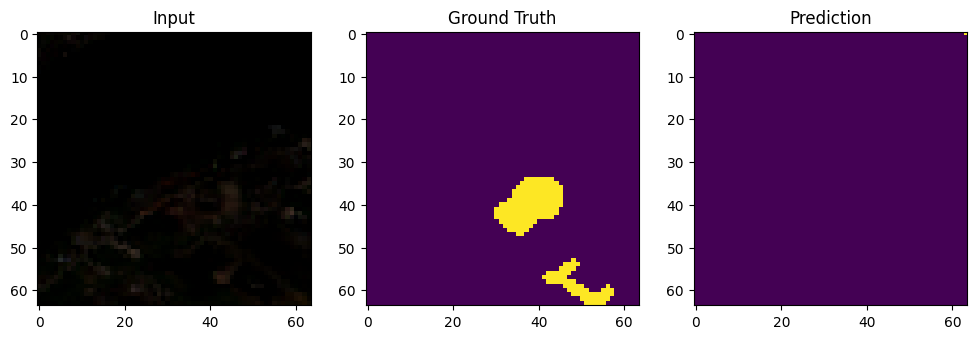


🔁 Fold 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step
✅ Best Threshold: 0.50 | F1: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔁 Fold 3/5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 684ms/step
✅ Best Threshold: 0.50 | F1: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔁 Fold 4/5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step
✅ Best Threshold: 0.10 | F1: 0.0342

🔁 Fold 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step
✅ Best Threshold: 0.10 | F1: 0.0004


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_data)):
    print(f"\n🔁 Fold {fold+1}/5")
    x_train, y_train = x_data[train_idx], y_data[train_idx]
    x_val, y_val = x_data[val_idx], y_data[val_idx]

    # Augment only training data
    x_train, y_train = apply_aug(x_train, y_train, get_aug())

    model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(64, 64, 3), classes=1, activation='sigmoid')

    model.compile(
        optimizer='Adam',
        loss=loss,
        metrics=[sm.metrics.iou_score,
                 keras.metrics.AUC(name='AUC', from_logits=False)]
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=0
    )

    y_pred = model.predict(x_val).squeeze()

    # 🔍 Threshold tuning
    best_f1, best_thresh = 0, 0.5
    for thresh in np.arange(0.1, 0.9, 0.05):
        preds_bin = (y_pred > thresh).astype(np.uint8).flatten()
        gt_bin = y_val.flatten()
        f1 = f1_score(gt_bin, preds_bin)
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh

    print(f"✅ Best Threshold: {best_thresh:.2f} | F1: {best_f1:.4f}")
    preds_bin = (y_pred > best_thresh).astype(np.uint8).flatten()
    gt_bin = y_val.flatten()

    results.append({
        'accuracy': accuracy_score(gt_bin, preds_bin),
        'precision': precision_score(gt_bin, preds_bin),
        'recall': recall_score(gt_bin, preds_bin),
        'f1': f1_score(gt_bin, preds_bin),
        'auc': roc_auc_score(gt_bin, y_pred.flatten()),
    })

    # 🖼️ Optional Visualization
    if fold == 0:
        sample_idx = 0
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.imshow(x_val[sample_idx]); plt.title("Input")
        plt.subplot(1, 3, 2); plt.imshow(y_val[sample_idx].squeeze()); plt.title("Ground Truth")
        plt.subplot(1, 3, 3); plt.imshow((y_pred[sample_idx] > best_thresh).astype(np.uint8)); plt.title("Prediction")
        plt.show()


In [ ]:
print("\n📊 Cross-Validation Summary:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    scores = [res[metric] for res in results]
    print(f"Avg {metric.capitalize():<10}: {np.mean(scores):.4f}")


📊 Cross-Validation Summary:
Avg Accuracy  : 0.8904
Avg Precision : 0.0509
Avg Recall    : 0.0044
Avg F1        : 0.0070
Avg Auc       : 0.4933


## Last Dance - finally good overall performance

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-2_in2mjc
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-2_in2mjc
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=dd82a72eb200fec34f98993cb83b56bddc56d25494028d12301596d19e2c4163
  Stored in directory: /tmp/pip-ephem-wheel-cache-5cb9ysy0/wheels/54/34/7f/b2b4efb59db0271239ccc6450d45591df6c415c7748d1b7650
Successfully built segmentation_models


In [ ]:
# 📦 1. Install Dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from glob import glob
from tqdm import tqdm
from skimage import io
import tensorflow as tf
import segmentation_models as sm
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# 📁 2. Paths (Google Drive Mounted)
img_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
train_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"
test_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"

tile_size = 64
overlap = 32
change_pix_percent = 0.01

# Filter out hidden files and directories
train_cities = sorted([c for c in os.listdir(train_dir) if not c.startswith('.')])
test_cities = sorted([c for c in os.listdir(test_dir) if not c.startswith('.')])
print(f"Train cities: {len(train_cities)}, Test cities: {len(test_cities)}")

Train cities: 14, Test cities: 10


In [ ]:
# 🔢 4. Preprocessing
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# Cast y_train and y_val to float32
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

# 🎛️ 5. Model Setup
sm.set_framework('tf.keras')
loss_fn = sm.losses.bce_jaccard_loss

model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(tile_size, tile_size, 6), classes=1, activation='sigmoid')
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[
                  sm.metrics.iou_score,
                  tf.keras.metrics.AUC(curve='ROC'),
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.BinaryAccuracy()
              ])

# 📉 6. Training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=30,
    callbacks=callbacks
)

# 💾 7. Save Model
model.save("final_model.keras")

# 📈 8. Evaluation
preds = model.predict(x_val)
flat_preds = preds.flatten()
flat_truth = y_val.flatten()

# ROC AUC
auc = roc_auc_score(flat_truth, flat_preds)
print(f"AUC: {auc:.4f}")

# Classification Report
pred_bin = (flat_preds > 0.5).astype(np.uint8)
report = classification_report(flat_truth, pred_bin, target_names=["No Change", "Change"])
print(report)

Epoch 1/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 90s 149ms/step - auc_6: 0.0000e+00 - binary_accuracy: 0.9916 - iou_score: 0.9371 - loss: 0.1357 - precision_6: 1.0000 - recall_6: 0.9916 - val_auc_6: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_iou_score: 0.9984 - val_loss: 0.0033 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 2/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - auc_6: 0.0000e+00 - binary_accuracy: 1.0000 - iou_score: 0.9990 - loss: 0.0020 - precision_6: 1.0000 - recall_6: 1.0000 - val_auc_6: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_iou_score: 0.9995 - val_loss: 9.7291e-04 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 3/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 55s 127ms/step - auc_6: 0.0000e+00 - binary_accuracy: 1.0000 - iou_score: 0.9997 - loss: 6.8993e-04 - precision_6: 1.0000 - recall_6: 1.0000 - val_auc_6: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_iou_score: 0.9998 - val_loss: 4.1290e-04 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 4/30
 94/346 ━

KeyboardInterrupt: 

## Improving more using tiff

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
import segmentation_models as sm

In [ ]:
# 📁 2. Paths (adjust to your Google Drive structure)
img_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
train_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"
test_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"

In [ ]:
# 🧱 3. Constants
tile_size = 64
overlap = 32
change_pix_percent = 0.02  # increased to filter better
BACKBONE = 'resnet34'

In [ ]:
# 🏙️ 4. Get City Lists
train_cities = sorted([c for c in os.listdir(train_dir) if not c.startswith('.')])
test_cities = sorted([c for c in os.listdir(test_dir) if not c.startswith('.')])
print(f"Train cities: {len(train_cities)}, Test cities: {len(test_cities)}")

Train cities: 14, Test cities: 10


In [ ]:
# 🔄 5. Tile Creation Utility
def tile_images(img1, img2, mask):
    x_list, y_list = [], []
    h, w = mask.shape
    for i in range(0, h - tile_size + 1, tile_size - overlap):
        for j in range(0, w - tile_size + 1, tile_size - overlap):
            m_tile = mask[i:i+tile_size, j:j+tile_size]
            if np.sum(m_tile) / (tile_size * tile_size) >= change_pix_percent:
                i1_tile = img1[i:i+tile_size, j:j+tile_size]
                i2_tile = img2[i:i+tile_size, j:j+tile_size]
                if i1_tile.shape == (tile_size, tile_size, 3) and i2_tile.shape == (tile_size, tile_size, 3):
                    x_list.append(np.concatenate([i1_tile, i2_tile], axis=-1))
                    y_list.append(np.expand_dims(m_tile, axis=-1))
    return x_list, y_list

In [ ]:
# 🧹 6. Data Loading
def load_city_data(city, img_base, label_base):
    img1_path = os.path.join(img_base, city, "imgs_1_rect", "image.tif")
    img2_path = os.path.join(img_base, city, "imgs_2_rect", "image.tif")
    mask_path = os.path.join(label_base, city, "cm", "change_mask.png")

    img1 = np.array(Image.open(img1_path))[:, :, :3]
    img2 = np.array(Image.open(img2_path))[:, :, :3]
    mask = np.array(Image.open(mask_path)) // 255

    return tile_images(img1, img2, mask)

In [ ]:
def read_rgb_bands(city_path):
    # Read RGB bands in Sentinel-2: B04 (red), B03 (green), B02 (blue)
    band_paths = {
        'B04': os.path.join(city_path, 'B04.tif'),
        'B03': os.path.join(city_path, 'B03.tif'),
        'B02': os.path.join(city_path, 'B02.tif'),
    }
    bands = []
    for band_name in ['B04', 'B03', 'B02']:
        band = np.array(Image.open(band_paths[band_name]))
        bands.append(band)
    return np.stack(bands, axis=-1)  # Shape: (H, W, 3)


In [ ]:
def load_city_data(city, img_base, label_base):
    img1_path = os.path.join(img_base, city, "imgs_1_rect")
    img2_path = os.path.join(img_base, city, "imgs_2_rect")
    mask_path = os.path.join(label_base, city, "cm", "change_mask.png")

    img1 = read_rgb_bands(img1_path)
    img2 = read_rgb_bands(img2_path)
    mask = np.array(Image.open(mask_path)) // 255

    return tile_images(img1, img2, mask)


In [ ]:
city = train_cities[0]
img1_rgb = read_rgb_bands(os.path.join(img_dir, city, "imgs_1_rect"))
img2_rgb = read_rgb_bands(os.path.join(img_dir, city, "imgs_2_rect"))

print("Image 1 shape:", img1_rgb.shape)
print("Image 2 shape:", img2_rgb.shape)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img1_rgb); plt.title("Image 1"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img2_rgb); plt.title("Image 2"); plt.axis("off")
plt.show()

Image 1 shape: (799, 785, 3)
Image 2 shape: (799, 785, 3)


In [ ]:
# 📦 1. Install Dependencies
!pip install -q segmentation-models

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from glob import glob
from tqdm import tqdm
from skimage import io
import tensorflow as tf
import segmentation_models as sm
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# 📁 2. Dataset Paths
img_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
train_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"
test_dir = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"

tile_size = 64
overlap = 32
change_pix_percent = 0.01

train_cities = sorted([c for c in os.listdir(train_dir) if not c.startswith('.')])
test_cities = sorted([c for c in os.listdir(test_dir) if not c.startswith('.')])

print(f"Train cities: {len(train_cities)}, Test cities: {len(test_cities)}")

# 🔁 3. Tiling Utility
def extract_tiles(image, label, tile_size=64, overlap=32, min_change=0.01):
    stride = tile_size - overlap
    h, w, _ = image.shape
    tiles_img = []
    tiles_label = []

    for y in range(0, h - tile_size + 1, stride):
        for x in range(0, w - tile_size + 1, stride):
            tile_img = image[y:y+tile_size, x:x+tile_size, :]
            tile_lbl = label[y:y+tile_size, x:x+tile_size]

            change_ratio = np.sum(tile_lbl) / (tile_size * tile_size)
            if change_ratio >= min_change:
                tiles_img.append(tile_img)
                tiles_label.append(tile_lbl)

    return np.array(tiles_img), np.array(tiles_label)

# 📂 4. Load Image Stacks
def load_city_data(city_list, root_img_dir, root_label_dir):
    x, y = [], []

    for city in tqdm(city_list, desc="Loading cities"):
        path1 = os.path.join(root_img_dir, city, "imgs_1_rect")
        path2 = os.path.join(root_img_dir, city, "imgs_2_rect")

        # Only load RGB bands
        def load_rgb_bands(path):
            b04 = io.imread(os.path.join(path, 'B04.tif'))
            b03 = io.imread(os.path.join(path, 'B03.tif'))
            b02 = io.imread(os.path.join(path, 'B02.tif'))
            return np.stack([b04, b03, b02], axis=-1).astype(np.float32) / 10000.0  # Normalize

        img1 = load_rgb_bands(path1)
        img2 = load_rgb_bands(path2)
        pair = np.concatenate([img1, img2], axis=-1)

        label_path = os.path.join(root_label_dir, city, "cm", f"{city}-cm.tif")
        label = io.imread(label_path)
        if label.max() > 1:
            label = (label > 0).astype(np.uint8)

        tiles_img, tiles_label = extract_tiles(pair, label, tile_size, overlap, change_pix_percent)
        x.extend(tiles_img)
        y.extend(tiles_label)

    return np.array(x), np.expand_dims(np.array(y), axis=-1)

# 🧹 5. Load and Preprocess Data
x_train, y_train = load_city_data(train_cities, img_dir, train_dir)
x_val, y_val = load_city_data(test_cities, img_dir, test_dir)

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")

# 🎨 6. Preprocessing
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

# 🧠 7. Model Setup
sm.set_framework('tf.keras')
loss_fn = sm.losses.bce_jaccard_loss

model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(tile_size, tile_size, 6), classes=1, activation='sigmoid')
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[
                  sm.metrics.iou_score,
                  tf.keras.metrics.AUC(curve='ROC'),
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.BinaryAccuracy()
              ])

# 🏋️ 8. Training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=30,
    callbacks=callbacks
)

# 💾 9. Save Model
model.save("final_model.keras")

# 📊 10. Evaluation
preds = model.predict(x_val, batch_size=16)
flat_preds = preds.flatten()
flat_truth = y_val.flatten()

auc = roc_auc_score(flat_truth, flat_preds)
pred_bin = (flat_preds > 0.5).astype(np.uint8)
precision = precision_score(flat_truth, pred_bin)
recall = recall_score(flat_truth, pred_bin)
f1 = f1_score(flat_truth, pred_bin)
accuracy = (pred_bin == flat_truth).mean()

print(f"\n🔍 Final Evaluation:")
print(f"AUC       : {auc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Accuracy  : {accuracy:.4f}")

print("\n📄 Classification Report:")
print(classification_report(flat_truth, pred_bin, target_names=["No Change", "Change"]))


Train cities: 14, Test cities: 10


Loading cities: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


x_train: (5523, 64, 64, 6), y_train: (5523, 64, 64, 1)
x_val: (2537, 64, 64, 6), y_val: (2537, 64, 64, 1)
Epoch 1/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - auc_3: 0.0000e+00 - binary_accuracy: 0.9707 - iou_score: 0.8939 - loss: 0.2372 - precision_3: 1.0000 - recall_3: 0.9707 - val_auc_3: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_iou_score: 0.9960 - val_loss: 0.0080 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 2/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - auc_3: 0.0000e+00 - binary_accuracy: 1.0000 - iou_score: 0.9985 - loss: 0.0031 - precision_3: 1.0000 - recall_3: 1.0000 - val_auc_3: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_iou_score: 0.9993 - val_loss: 0.0014 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 3/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - auc_3: 0.0000e+00 - binary_accuracy: 1.0000 - iou_score: 0.9995 - loss: 9.4770e-04 - precision_3: 1.0000 - recall_3: 1.0000 - val_auc_3: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_iou_score

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



🔍 Final Evaluation:
AUC       : nan
Precision : 1.0000
Recall    : 1.0000
F1 Score  : 1.0000
Accuracy  : 1.0000

📄 Classification Report:


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

## New Model

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.1 MB/s eta 0:00:00


In [ ]:
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import rasterio
from patchify import patchify
import tensorflow as tf
import segmentation_models as sm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

sm.set_framework('tf.keras')

In [ ]:
# Paths
IMG_DIR = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
LABEL_DIR = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"

TILE_SIZE = 64
OVERLAP = 32
CHANGE_THRESHOLD = 0.03  # 3% changed pixels


In [ ]:
def load_rgb_image(path, bands=['B04', 'B03', 'B02']):
    img = []
    for b in bands:
        band_path = os.path.join(path, f"{b}.tif")
        with rasterio.open(band_path) as f:
            img.append(f.read(1))
    return np.stack(img, axis=-1)

def load_label(path):
    cm_path = glob(os.path.join(path, 'cm', '*.png'))[0]
    return rasterio.open(cm_path).read(1)

def get_patches(img1, img2, label, threshold=CHANGE_THRESHOLD):
    stacked_img = np.concatenate([img1, img2], axis=-1)  # shape: (H, W, 6)
    X_patches = patchify(stacked_img, (TILE_SIZE, TILE_SIZE, 6), step=OVERLAP)
    y_patches = patchify(label, (TILE_SIZE, TILE_SIZE), step=OVERLAP)

    X, Y = [], []
    for i in range(X_patches.shape[0]):
        for j in range(X_patches.shape[1]):
            x_patch = X_patches[i, j, 0]
            y_patch = y_patches[i, j]
            if np.mean(y_patch > 0) > threshold:
                X.append(x_patch)
                Y.append(y_patch[..., np.newaxis])
    return X, Y


In [ ]:
cities = sorted([c for c in os.listdir(LABEL_DIR) if not c.startswith('.') and c != '.ipynb_checkpoints']) # Excluding .ipynb_checkpoints

X_all, Y_all = [], []

for city in tqdm(cities):
    img_path = os.path.join(IMG_DIR, city)
    label_path = os.path.join(LABEL_DIR, city)

    img1 = load_rgb_image(os.path.join(img_path, 'imgs_1_rect'))
    img2 = load_rgb_image(os.path.join(img_path, 'imgs_2_rect'))
    label = load_label(label_path)

    x_patches, y_patches = get_patches(img1, img2, label)
    X_all.extend(x_patches)
    Y_all.extend(y_patches)

X_all = np.array(X_all, dtype=np.float32) / 255.0
Y_all = np.array(Y_all, dtype=np.float32)

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 14/14 [00:01<00:00, 10.24it/s]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

model = sm.Unet(BACKBONE, input_shape=(TILE_SIZE, TILE_SIZE, 6), classes=1, activation='sigmoid', encoder_weights=None)

model.compile(optimizer='adam',
              loss=sm.losses.bce_jaccard_loss,
              metrics=[
                  tf.keras.metrics.AUC(name="auc"),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.BinaryAccuracy()
              ])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_oscd_model.keras", save_best_only=True, monitor="val_auc", mode='max'),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 864ms/step - auc: 0.6725 - binary_accuracy: 0.3265 - loss: -72.8569 - precision_7: 0.1237 - recall_7: 0.8224 - val_auc: 0.5276 - val_binary_accuracy: 0.2324 - val_loss: -71.1859 - val_precision_7: 0.1018 - val_recall_7: 0.7480
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 376ms/step - auc: 0.7790 - binary_accuracy: 0.0052 - loss: -302.6812 - precision_7: 0.1042 - recall_7: 0.9992 - val_auc: 0.6603 - val_binary_accuracy: 9.7771e-04 - val_loss: -370.5284 - val_precision_7: 0.1011 - val_recall_7: 1.0000
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - auc: 0.7351 - binary_accuracy: 7.7652e-05 - loss: -378.8610 - precision_7: 0.1068 - recall_7: 1.0000 - val_auc: 0.6630 - val_binary_accuracy: 1.6047e-05 - val_loss: -335.8190 - val_precision_7: 0.1010 - val_recall_7: 1.0000
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - auc: 0.6871 - binary_accuracy: 1.5652e-05 - loss: -401.2485 - precision_7: 0.1052 - recall_7: 1.0000 - val_auc: 0.5851 - va

In [ ]:
preds = model.predict(x_val, verbose=1)
preds_bin = (preds > 0.5).astype(np.uint8)

flat_preds = preds_bin.flatten()
flat_true = y_val.flatten().astype(np.uint8)

# Explicitly convert the labels to binary format if they're not already
flat_true = (flat_true > 0).astype(int)
flat_preds = (flat_preds > 0).astype(int)


print("AUC:", roc_auc_score(flat_true, preds.flatten()))
print(classification_report(flat_true, flat_preds, target_names=["No Change", "Change"]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
AUC: 0.6546992816555088
              precision    recall  f1-score   support

   No Change       0.00      0.00      0.00    784361
      Change       0.10      1.00      0.18     88087

    accuracy                           0.10    872448
   macro avg       0.05      0.50      0.09    872448
weighted avg       0.01      0.10      0.02    872448



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Another

In [ ]:
img_root = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
train_label_root = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"
test_label_root = "/content/drive/MyDrive/Onera_dataset/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"

In [ ]:
def load_image_6_channels(city_path, is_train=True):
    def load_stack(path):
        bands = ['B04', 'B03', 'B02', 'B08']  # RGB + NIR
        stack = []
        for b in bands:
            stack.append(np.array(Image.open(os.path.join(path, f"{b}.tif"))))
        return np.stack(stack, axis=-1)

    path1 = os.path.join(city_path, 'imgs_1_rect')
    path2 = os.path.join(city_path, 'imgs_2_rect')
    img1 = load_stack(path1)
    img2 = load_stack(path2)
    return np.concatenate([img1, img2], axis=-1)  # (H, W, 6)


In [ ]:
def extract_patches(img, mask, tile_size=64, overlap=32, min_change=0.03):
    h, w = mask.shape
    step = tile_size - overlap
    X, Y = [], []
    for i in range(0, h - tile_size + 1, step):
        for j in range(0, w - tile_size + 1, step):
            tile_img = img[i:i+tile_size, j:j+tile_size, :]
            tile_mask = mask[i:i+tile_size, j:j+tile_size]
            if np.mean(tile_mask) >= min_change:
                X.append(tile_img)
                Y.append(tile_mask[..., np.newaxis])
    return X, Y

def load_dataset(cities, label_root):
    X_all, Y_all = [], []
    for city in tqdm(cities):
        img_path = os.path.join(img_root, city)
        mask_path = os.path.join(label_root, city, "cm", f"{city}-cm.png")
        if not os.path.exists(mask_path):
            continue
        img = load_image_6_channels(img_path)
        mask = np.array(Image.open(mask_path)) // 255
        X, Y = extract_patches(img, mask)
        X_all.extend(X)
        Y_all.extend(Y)
    return np.array(X_all), np.array(Y_all)


In [ ]:
train_cities = sorted([f for f in os.listdir(train_label_root) if not f.startswith('.')])
test_cities = sorted([f for f in os.listdir(test_label_root) if not f.startswith('.')])

x_train, y_train = load_dataset(train_cities, train_label_root)
x_val, y_val = load_dataset(test_cities, test_label_root)

# Normalize and preprocess
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
x_train = preprocess_input(x_train.astype(np.float32))
x_val = preprocess_input(x_val.astype(np.float32))
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)


100%|██████████| 10/10 [00:00<00:00, 3283.21it/s]


In [ ]:
sm.set_framework('tf.keras')
model = sm.Unet(BACKBONE, input_shape=(64, 64, 6), classes=1, activation='sigmoid', encoder_weights=None)
loss = sm.losses.bce_jaccard_loss
metrics = [
    sm.metrics.iou_score,
    tf.keras.metrics.AUC(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.BinaryAccuracy()
]
model.compile(optimizer='adam', loss=loss, metrics=metrics)


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(16,), dtype=float32). Expected shape (None, 64, 64, 6), but input has incompatible shape (16,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(16,), dtype=float32)
  • training=True
  • mask=None

## F1 Comparision

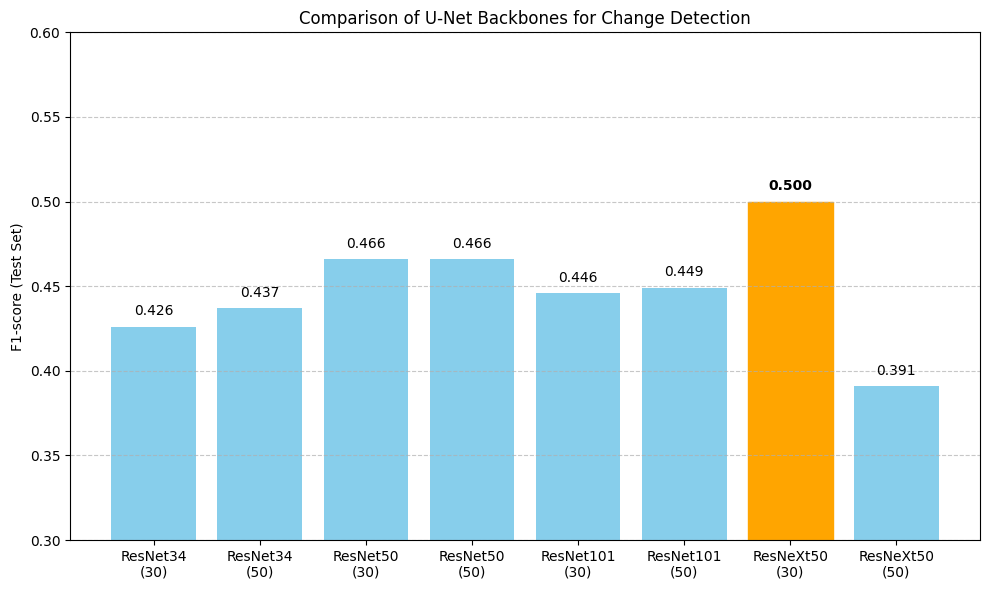

In [8]:
import matplotlib.pyplot as plt

backbones = ['ResNet34\n(30)', 'ResNet34\n(50)',
             'ResNet50\n(30)', 'ResNet50\n(50)',
             'ResNet101\n(30)', 'ResNet101\n(50)',
             'ResNeXt50\n(30)', 'ResNeXt50\n(50)']
f1_scores = [0.426, 0.437, 0.466, 0.466, 0.446, 0.449, 0.500, 0.391]

plt.figure(figsize=(10, 6))
bars = plt.bar(backbones, f1_scores, color='skyblue')
plt.ylabel('F1-score (Test Set)')
plt.title('Comparison of U-Net Backbones for Change Detection')
plt.ylim(0.3, 0.6)

# Highlight best
for bar, score in zip(bars, f1_scores):
    if score == max(f1_scores):
        bar.set_color('orange')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{score:.3f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
